In [1]:
from models import *
from used_packages import *
from utils import *

In [2]:
data_bank = pd.read_csv('data/bs140513_032310.csv').drop(columns=['zipcodeOri', 'zipMerchant'])

In [3]:
data_bank.head()

step       customer  age gender       merchant             category  \
0     0  'C1093826151'  '4'    'M'   'M348934600'  'es_transportation'   
1     0   'C352968107'  '2'    'M'   'M348934600'  'es_transportation'   
2     0  'C2054744914'  '4'    'F'  'M1823072687'  'es_transportation'   
3     0  'C1760612790'  '3'    'M'   'M348934600'  'es_transportation'   
4     0   'C757503768'  '5'    'M'   'M348934600'  'es_transportation'   

   amount  fraud  
0    4.55      0  
1   39.68      0  
2   26.89      0  
3   17.25      0  
4   35.72      0

In [4]:
# removing single quotes
object_columns = data_bank.select_dtypes('object').columns
for col in object_columns:
    data_bank[col] = data_bank[col].str.replace("'", "")
data_bank

# removing es_ from category
data_bank['category'] = data_bank['category'].str.replace('es_', '')

In [5]:
best_recall = dict()

In [6]:
from collections import defaultdict
scores_plot = defaultdict(float)

In [7]:
data_bank.head()

step     customer age gender     merchant        category  amount  fraud
0     0  C1093826151   4      M   M348934600  transportation    4.55      0
1     0   C352968107   2      M   M348934600  transportation   39.68      0
2     0  C2054744914   4      F  M1823072687  transportation   26.89      0
3     0  C1760612790   3      M   M348934600  transportation   17.25      0
4     0   C757503768   5      M   M348934600  transportation   35.72      0

### Missing data
No missing data

In [8]:
data_bank.isnull().sum() + data_bank.isna().sum()

step        0
customer    0
age         0
gender      0
merchant    0
category    0
amount      0
fraud       0
dtype: int64

### Unique entries & Data types
Large number of categorical variables

In [9]:
pd.concat((data_bank.dtypes.rename('Data_Types'), data_bank.nunique().rename('Unique_Entries')), axis=1)

Data_Types  Unique_Entries
step          int64             180
customer     object            4112
age          object               8
gender       object               4
merchant     object              50
category     object              15
amount      float64           23767
fraud         int64               2

In [10]:
data_new = data_bank.copy()

### Sparse dimensions

Count of datapoints per customer in asceding order. Taking the 50th position the count is still 14, i.e., there are at least 50 dimensions that have a maximum of 14 datapoints, indicating that many of the dimensions are sparse.

In [11]:
data_bank.groupby(['customer'])['customer'].count().sort_values().iloc[:50]

customer
C1404665203     5
C1743702978     5
C1809646275     5
C1345586046     6
C1156745710     6
C1233811793     7
C849065220      7
C1924305208     7
C1432191075     7
C730733765      8
C792820521      8
C28065321       8
C1564636486     8
C1225568299     8
C1131883667     8
C650117238      8
C64314422       8
C1066003783     9
C601255458      9
C1136761152     9
C79727066       9
C1657671280     9
C1689346810     9
C2008400862     9
C130979586      9
C395414939     10
C710270523     10
C1235359960    10
C1196611038    10
C1562081159    10
C181413412     10
C243130666     10
C140804810     11
C746711867     11
C510795907     11
C1619197936    12
C1571595392    12
C1822295676    12
C274486575     12
C1337135199    12
C1204835011    12
C342292849     12
C1156399058    12
C2060410910    13
C895561340     13
C2033917877    13
C611520731     13
C1526367312    13
C1560904250    13
C1747786179    14
Name: customer, dtype: int64

### Count per categorical variable sorted

In [12]:
d = 1
group_cust_count = data_bank.groupby(['customer'])['customer'].count().sample(frac=d, random_state=0).sort_values()
group_merch_count = data_bank.groupby(['merchant'])['merchant'].count().sample(frac=d, random_state=0).sort_values()
group_cat_count = data_bank.groupby(['category'])['category'].count().sample(frac=d, random_state=0).sort_values()
group_age_count = data_bank.groupby(['age'])['age'].count().sample(frac=d, random_state=0).sort_values()
group_gender_count = data_bank.groupby(['gender'])['gender'].count().sample(frac=d, random_state=0).sort_values()


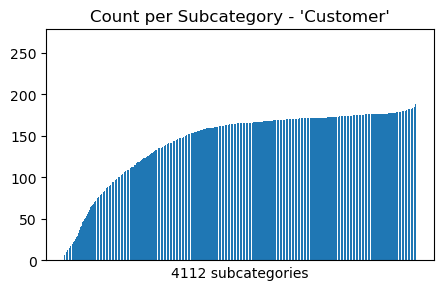

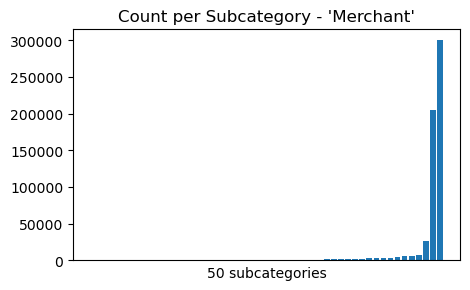

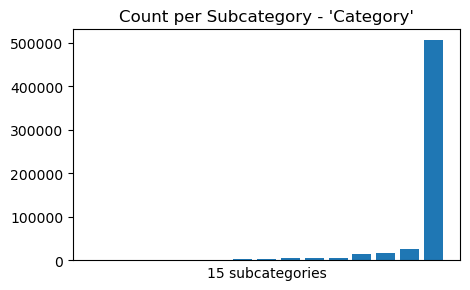

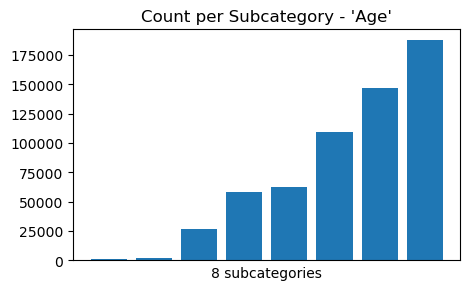

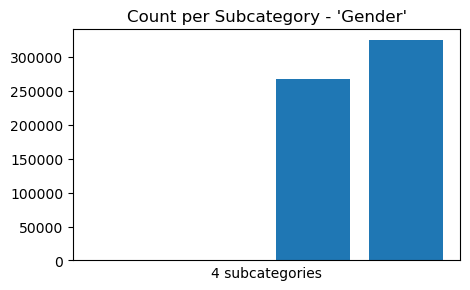

In [13]:
bar_plot(group_cust_count, x_label=f'{len(group_cust_count)} subcategories',
           main_title=f"Count per Subcategory - 'Customer'", ylim=None,
           yticks=True, fig_size=(5, 3), num_percentiles=0, save_plot=False)
bar_plot(group_merch_count, x_label=f'{len(group_merch_count)} subcategories',
           main_title=f"Count per Subcategory - 'Merchant'", ylim=None,
           yticks=True, fig_size=(5, 3), num_percentiles=0, save_plot=False)
bar_plot(group_cat_count, x_label=f'{len(group_cat_count)} subcategories',
           main_title=f"Count per Subcategory - 'Category'", ylim=None,
           yticks=True, fig_size=(5, 3), num_percentiles=0, save_plot=False)
bar_plot(group_age_count, x_label=f'{len(group_age_count)} subcategories',
           main_title=f"Count per Subcategory - 'Age'", ylim=None,
           yticks=True, fig_size=(5, 3), num_percentiles=0, save_plot=False)
bar_plot(group_gender_count, x_label=f'{len(group_gender_count)} subcategories',
           main_title=f"Count per Subcategory - 'Gender'", ylim=None,
           yticks=True, fig_size=(5, 3), num_percentiles=0, save_plot=False)

### Data out of balance

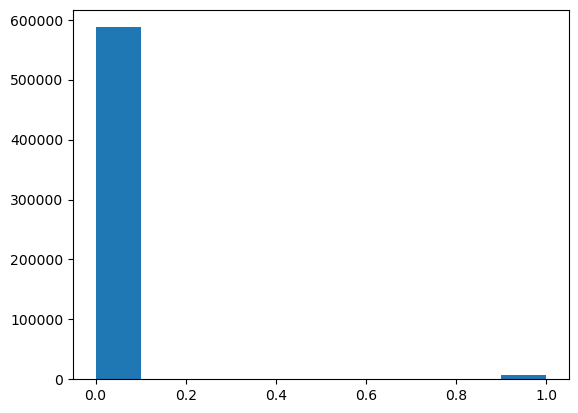

In [14]:
plt.hist(data_bank['fraud'], bins=10)
plt.show()

In [15]:
data_bank['fraud'].value_counts()

0    587443
1      7200
Name: fraud, dtype: int64

## I will add all new features to data_new and then drop them as I need when testing models

### Feature 1 : Grouping merchants based on quantiles of total amount spent per merchant (merchants with similar total spending grouped together)

In [16]:
group_merch_amnt = data_bank.groupby(['merchant']).apply(lambda x: x['amount'].sum())
merch_percent_amnt = group_merch_amnt.quantile([0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875])
data_new['quant_merch_amnt'] = data_new.apply(lambda x: assign_quantile_group(x, group_merch_amnt, merch_percent_amnt, 'merchant'), axis=1)


data_new['quant_merch_amnt'].unique()

array(['8', '5', '6', '1', '7', '4', '2', '3'], dtype=object)

### Feature 2: Grouping categories based on quantiles of total amount spent per category (categories with similar total spending grouped together)


In [17]:
group_cat_amnt = data_bank.groupby(['category']).apply(lambda x: x['amount'].sum())
cat_percent_amnt = group_cat_amnt.quantile([0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875])
data_new['quant_cat_amnt'] = data_new.apply(lambda x: assign_quantile_group(x, group_cat_amnt, cat_percent_amnt, 'category'), axis=1)

data_new['quant_cat_amnt'].unique()


array(['8', '1', '6', '5', '2', '3', '7', '4'], dtype=object)

### Feature 3: Grouping customers based on quantiles of total amount spent per customer (customers with similar total spending grouped together)



In [18]:
group_cust_amnt = data_bank.groupby(['customer']).apply(lambda x: x['amount'].sum())
cust_percent_amnt = group_cust_amnt.quantile([0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875])
data_new['quant_cust_amnt'] = data_new.apply(lambda x: assign_quantile_group(x, group_cust_amnt, cust_percent_amnt, 'customer'), axis=1)

data_new['quant_cust_amnt'].unique()

array(['3', '6', '1', '5', '2', '7', '8', '4'], dtype=object)

### Feature 4: fraud to non-fraud ratio per customer

In [19]:
def ratio(group):
    group['ratio_fraud'] = group['fraud'].sum() / len(group)
    return group

data_new = data_new.groupby('customer').apply(ratio)

### Feature 5: number of transactions per customer

In [20]:
def tot_trans(group):
    group['total_trans'] = len(group)
    return group

data_new = data_new.groupby('customer').apply(tot_trans)

### Feature 6: total amount spent per customer

In [21]:
def tot_amount(group):
    group['cust_spend'] = group['amount'].sum()
    return group

data_new = data_new.groupby(['customer']).apply(tot_amount)

### Feature 7: total amount spent per customer per merchant

In [22]:
def tot_cust_merch(group):
    group['merch_spend'] = group['amount'].sum()
    return group

data_new = data_new.groupby(['customer', 'merchant']).apply(tot_cust_merch)

### Feature 8: total amount spent per customer per category

In [23]:
def tot_cust_cat(group):
    group['cat_spend'] = group['amount'].sum()
    return group

data_new = data_new.groupby(['customer', 'category']).apply(tot_cust_cat)

In [24]:
data_new.head(6)

step     customer age gender     merchant        category  amount  fraud  \
0     0  C1093826151   4      M   M348934600  transportation    4.55      0   
1     0   C352968107   2      M   M348934600  transportation   39.68      0   
2     0  C2054744914   4      F  M1823072687  transportation   26.89      0   
3     0  C1760612790   3      M   M348934600  transportation   17.25      0   
4     0   C757503768   5      M   M348934600  transportation   35.72      0   
5     0  C1315400589   3      F   M348934600  transportation   25.81      0   

  quant_merch_amnt quant_cat_amnt quant_cust_amnt  ratio_fraud  total_trans  \
0                8              8               3          0.0          167   
1                8              8               6          0.0          169   
2                8              8               1          0.0           65   
3                8              8               5          0.0          171   
4                8              8               2          0.0          145   
5                8              8               7          0.0          175   

   cust_spend  merch_spend  cat_spend  
0     4716.20      4308.77    4308.77  
1     5519.77      2043.61    4412.56  
2     2693.84       753.93    1485.21  
3     5187.93      1372.26    4195.08  
4     4596.03      1948.67    3545.14  
5     5739.56       212.74    3893.96

### Feature 9, 10, 11: grouping categorical variables based on their LASSO coefs
The lasso coefs were obtained further down in the notebook, saved and loaded back here to save time as running a lasso model with over 4000 variables is quite slow.

Age and gender do not have a large number of subcategories, so I decided to keep them as is

In [25]:
coefs_lasso = pd.read_csv('data/LASSO coefs l1reg=0.00001 w-o intercept.csv')

In [26]:
coefs_lasso['cat'] = coefs_lasso['cat'].str.replace('customer_', '')
coefs_lasso['cat'] = coefs_lasso['cat'].str.replace('merchant_', '')
coefs_lasso['cat'] = coefs_lasso['cat'].str.replace('category_', '')
coefs_lasso['cat'] = coefs_lasso['cat'].str.replace('age_', '')
coefs_lasso['cat'] = coefs_lasso['cat'].str.replace('gender_', '')

In [27]:
group_cust_lass = coefs_lasso[coefs_lasso['group_label'] == 1].sort_values(by=['coef'], ascending=False).set_index('cat')['coef']
group_merch_lass = coefs_lasso[coefs_lasso['group_label'] == 2].sort_values(by=['coef'], ascending=False).set_index('cat')['coef']
group_cat_lass = coefs_lasso[coefs_lasso['group_label'] == 3].sort_values(by=['coef'], ascending=False).set_index('cat')['coef']
group_age_lass = coefs_lasso[coefs_lasso['group_label'] == 4].sort_values(by=['coef'], ascending=False).set_index('cat')['coef']
group_gender_lass = coefs_lasso[coefs_lasso['group_label'] == 5].sort_values(by=['coef'], ascending=False).set_index('cat')['coef']


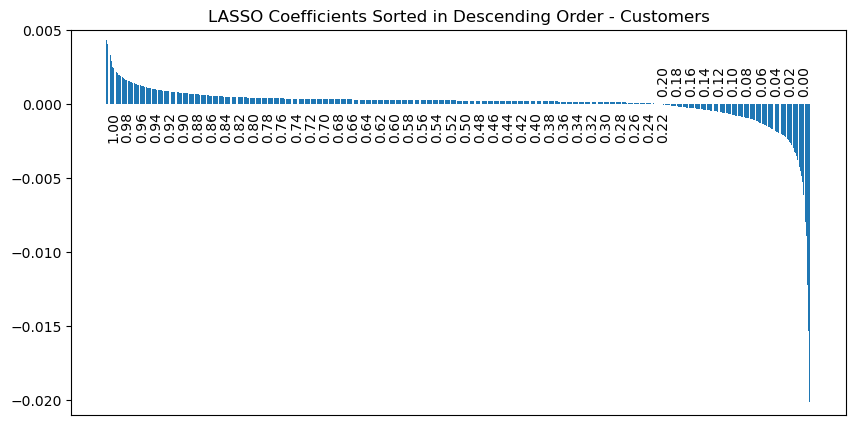

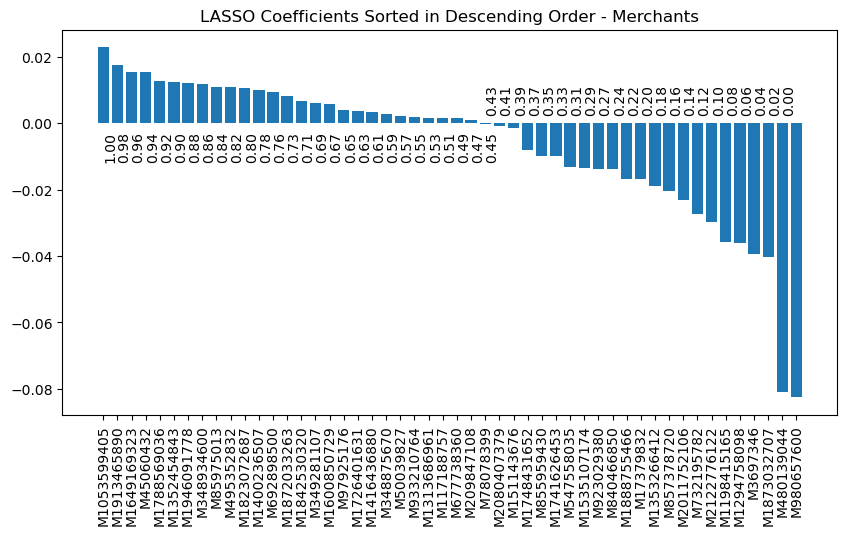

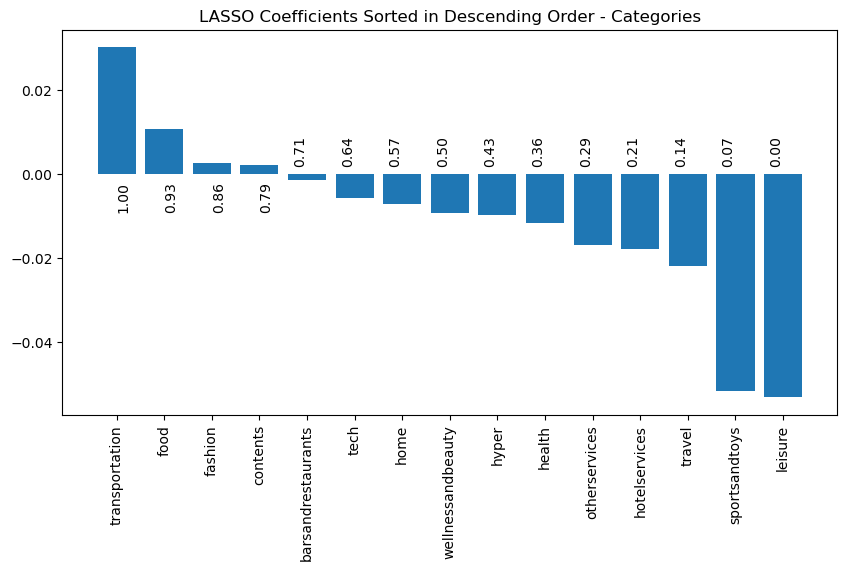

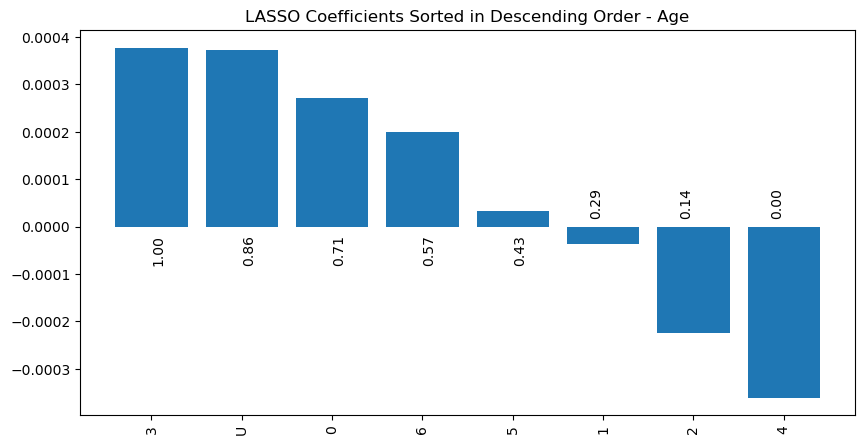

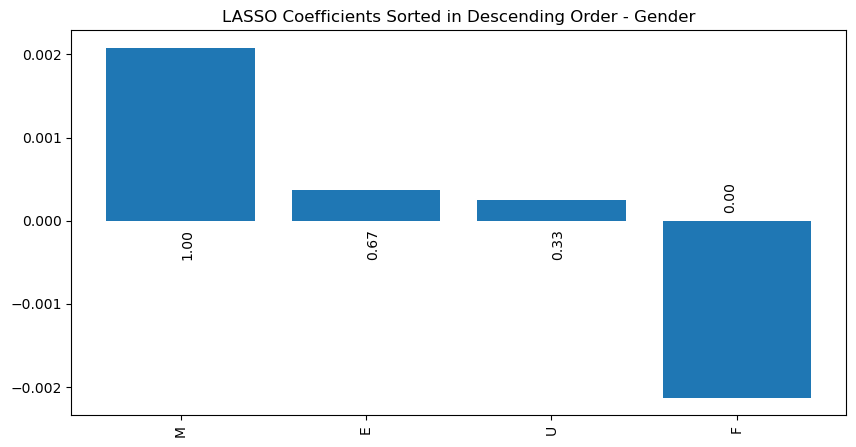

In [28]:
bar_plot(group_cust_lass,
           main_title='LASSO Coefficients Sorted in Descending Order - Customers', ylim=(-0.021,0.005),
           fig_size=(10, 5), num_percentiles=50, save_plot=False)
bar_plot(group_merch_lass,
           main_title='LASSO Coefficients Sorted in Descending Order - Merchants', ylim=None,
           fig_size=(10, 5), num_percentiles=49, xticks=True, save_plot=False)
bar_plot(group_cat_lass,
           main_title='LASSO Coefficients Sorted in Descending Order - Categories', ylim=None,
           fig_size=(10, 5), num_percentiles=14, xticks=True, save_plot=False)
bar_plot(group_age_lass,
           main_title='LASSO Coefficients Sorted in Descending Order - Age', ylim=None,
           fig_size=(10, 5), num_percentiles=7, xticks=True, save_plot=False)
bar_plot(group_gender_lass,
           main_title='LASSO Coefficients Sorted in Descending Order - Gender', ylim=None,
           fig_size=(10, 5), num_percentiles=3, xticks=True, save_plot=False)

In [29]:
# break points were determined by visually inspecting the above bar plots
merch_percent = group_merch_lass.quantile([0.03, 0.07, 0.375, 0.17, 0.3, 0.6, 0.9])
cat_percent = group_cat_lass.quantile([0.1, 0.4, 0.6, 0.9, 0.96])
cust_percent = group_cust_lass.quantile([0.01, 0.02, 0.0275, 0.97, 0.99])

In [30]:
# add features to dataframe
data_new['quant_merch_coef'] = data_new.apply(lambda x: assign_quantile_group(x, group_merch_lass, merch_percent, 'merchant'), axis=1)
data_new['quant_cat_coef'] = data_new.apply(lambda x: assign_quantile_group(x, group_cat_lass, cat_percent, 'category'), axis=1)
data_new['quant_cust_coef'] = data_new.apply(lambda x: assign_quantile_group(x, group_cust_lass, cust_percent, 'customer'), axis=1)

In [31]:
data_new.head()

step     customer age gender     merchant        category  amount  fraud  \
0     0  C1093826151   4      M   M348934600  transportation    4.55      0   
1     0   C352968107   2      M   M348934600  transportation   39.68      0   
2     0  C2054744914   4      F  M1823072687  transportation   26.89      0   
3     0  C1760612790   3      M   M348934600  transportation   17.25      0   
4     0   C757503768   5      M   M348934600  transportation   35.72      0   

  quant_merch_amnt quant_cat_amnt quant_cust_amnt  ratio_fraud  total_trans  \
0                8              8               3          0.0          167   
1                8              8               6          0.0          169   
2                8              8               1          0.0           65   
3                8              8               5          0.0          171   
4                8              8               2          0.0          145   

   cust_spend  merch_spend  cat_spend quant_merch_coef quant_cat_coef  \
0     4716.20      4308.77    4308.77                7              6   
1     5519.77      2043.61    4412.56                7              6   
2     2693.84       753.93    1485.21                7              6   
3     5187.93      1372.26    4195.08                7              6   
4     4596.03      1948.67    3545.14                7              6   

  quant_cust_coef  
0               4  
1               4  
2               4  
3               4  
4               4

In [32]:
pd.concat((data_new.dtypes.rename('Data_Types'), data_new.nunique().rename('Unique_Entries')), axis=1)

Data_Types  Unique_Entries
step                  int64             180
customer             object            4112
age                  object               8
gender               object               4
merchant             object              50
category             object              15
amount              float64           23767
fraud                 int64               2
quant_merch_amnt     object               8
quant_cat_amnt       object               8
quant_cust_amnt      object               8
ratio_fraud         float64             633
total_trans           int64             192
cust_spend          float64            4094
merch_spend         float64           33660
cat_spend           float64           26369
quant_merch_coef     object               6
quant_cat_coef       object               6
quant_cust_coef      object               6

# Comparison:

### (1) All original variables
### (2) All original variables, train on 10% of the training data
### (3) All original variables except cust
### (4) All original variables except cust, cat, merch
### (5) Grouping cust, cat, merch based on AMOUNT SPENT
### (6) Grouping cust, cat, merch based on LASSO COEFFICIENTS (much better model)
### (7) Same as (6), Remove age, gender, step, add new features
### (8) Same as (7), train on 10% of the training data
### (9) Same as (7), reduce the count of class 0 in the training set
### (10) Same as (9), further reduce the count of class 0 in the training set to balance it with class1


# (1) All Original Variables - Baseline

## G-LASSO - Original variables - obtain lasso coefs to use for grouping categorical variables

In [217]:
data_new_reduced = data_new.copy()
data_temp = data_new_reduced[['customer', 'merchant', 'category', 'age', 'gender', 'step', 'amount', 'fraud']].sample(frac=1, random_state=0)

# [['merchant', 'category', 'age', 'gender', 'step', 'amount', 'fraud']]

data3, X, y = one_hot_encode_pandas(data_temp, response='fraud', except_col=['fraud'], drop_first=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
l1_reg = 0.00001 #np.linspace(0,0.1,100)
title = f'- G-LASS - Original Variables \n w [customer merchant category age.. \n ..gender step amount] Unbalanced Training'
original_labels = data_temp.drop(columns=['fraud']).columns.tolist()
model_gl2, coefs_gl2, lam_gl2, ypred_gl, group_lass_labels, labels, f1_scores = (
    glasso_paths(X_train, y_train, X_test, original_labels,
                 c_start=-5, c_stop=2, c_num=5,
                 scoring='f1',
                 no_groups=False,
                 l1_reg=l1_reg,
                 n_iter=50,
                 tol=1e-3,
                 cmap='tab10',
                 title=title,
                 verbose=True))

Original Labels
['customer', 'merchant', 'category', 'age', 'gender', 'step', 'amount']

Group Numbers
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

## Ridge - Original variables

In [23]:
data_new_reduced = data_new.copy()
data_temp = data_new_reduced[['customer', 'merchant', 'category', 'age', 'gender', 'step', 'amount', 'fraud']].sample(frac=1, random_state=0)

# [['merchant', 'category', 'age', 'gender', 'step', 'amount', 'fraud']]

data3, X, y = one_hot_encode_pandas(data_temp, response='fraud', except_col=['fraud'], drop_first=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Original Labels
['customer', 'merchant', 'category', 'age', 'gender', 'step', 'amount']

Group Numbers (Groups used for plotting purposes not for regularization)
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

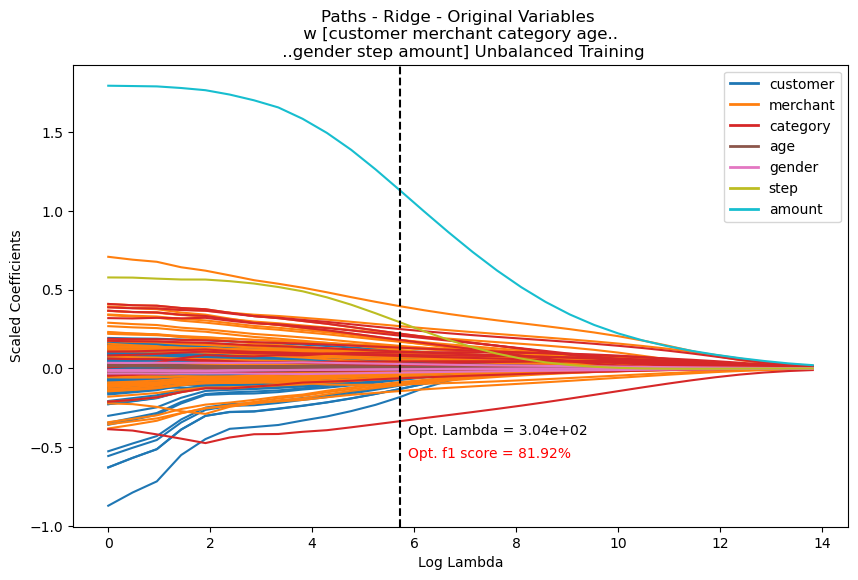

In [218]:
title = f'- Ridge - Original Variables \n w [customer merchant category age.. \n ..gender step amount] Unbalanced Training'
original_labels = data_temp.drop(columns=['fraud']).columns.tolist()
model_r, coefs_r, lam_r, ypred_r, group_lass_labels, labels, scores_r = (
    ridge_paths(X_train, y_train, X_test, original_labels,
                c_start=-6, c_stop=0, c_num=30,
                scoring='f1',
                n_iter=100,
                tol=1e-3,
                cmap='tab10',
                title=title,
                verbose=True,
                save_plot=False))

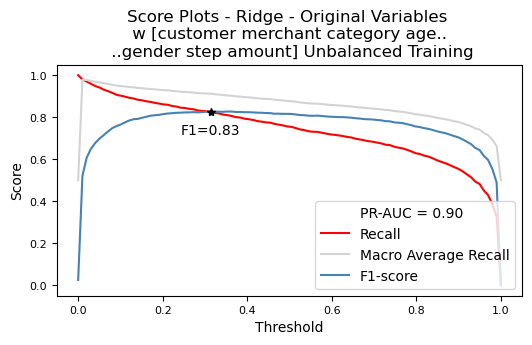

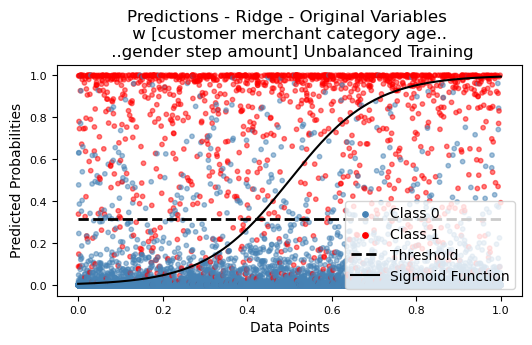

######### Ridge - Original Variables - w [customer merchant category age.. - ..gender step amount] Unbalanced Training #########
Confusion Matrix - Optimal Threshold = 0.313

     0    1
117186  256
   258 1229

Classification Report - Optimal Threshold = 0.313

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117442
           1       0.83      0.83      0.83      1487

    accuracy                           1.00    118929
   macro avg       0.91      0.91      0.91    118929
weighted avg       1.00      1.00      1.00    118929



In [139]:
full_class_report(y_test, ypred_r, title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  criterion='f1_recall_diff',
                  sample0=1,
                  legend_loc='lower right', save_plot=False)

In [ ]:
_, pr_auc_r_original, recall_r_original, f1_r_original, recall_macro_r_original = (
    classification_plots(y_test, ypred_r, l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [220]:
print(f'pr_auc_r_original: {pr_auc_r_original},\nrecall_r_original: {recall_r_original},\nf1_r_original: {f1_r_original},\nrecall_macro_r_original: {recall_macro_r_original},')

pr_auc_r_original: 0.8955909032766755,
recall_r_original: 0.8264963012777404,
f1_r_original: 0.8270524899057875,
recall_macro_r_original: 0.9121582509437015,


In [221]:
beset_recall_r_original = best_recall_thresh(y_test, ypred_r, 'r_original', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_r_original)

In [222]:
scr_r_original = {
    'pr_auc_r_original': pr_auc_r_original,
    'recall_r_original': recall_r_original,
    'f1_r_original': f1_r_original,
    'recall_macro_r_original': recall_macro_r_original
}
scores_plot.update(scr_r_original)

In [42]:
'''file_coef = pd.DataFrame({'cat': X_train.columns,'group_label': group_lass_labels, 'coef': coefs_r.T[:,0]}, index=None)
file_coef.to_csv('data/coefs ridge w-o intercept full training set.csv')'''

## SVM - Original variables

### Will take 7.2 days to finish on an intel i7 chip if the full training set was used. I used 20% only, resulted in a bad model

In [25]:
data_small = pd.concat([X_train, y_train], axis=1).sample(frac=0.2, random_state=0)
X_trains = data_small.drop(columns=['fraud'])
y_trains = data_small['fraud']

In [ ]:
C = [0.01]
bias = range(1)

svm_values = svm_model(X_train, y_train, X_test, y_test,
                        C, kernel='poly',
                        degree=3,
                        bias=bias,
                        scoring='recall_macro',
                        verbose=True)

1. C = 0.01
    bias: 0
[LibSVM]

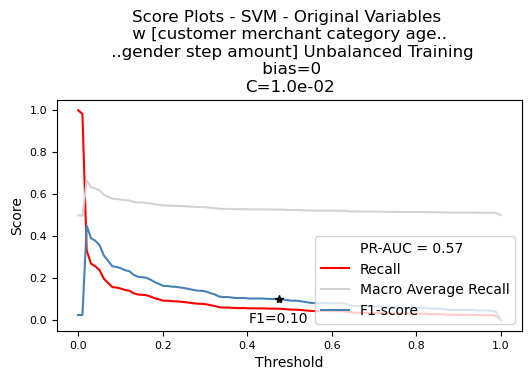

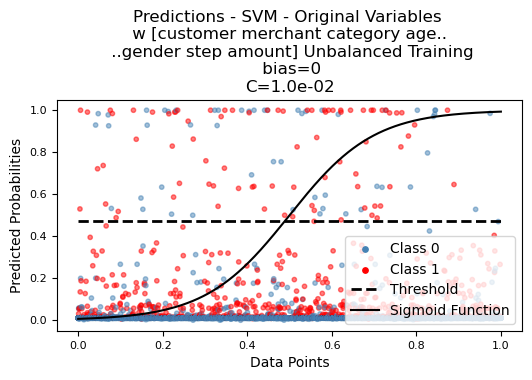

######### SVM - Original Variables - w [customer merchant category age.. - ..gender step amount] Unbalanced Training- bias=0-C=1.0e-02 #########
Confusion Matrix - Optimal Threshold = 0.475

     0  1
117391 51
  1406 81

Classification Report - Optimal Threshold = 0.475

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    117442
           1       0.61      0.05      0.10      1487

    accuracy                           0.99    118929
   macro avg       0.80      0.53      0.55    118929
weighted avg       0.98      0.99      0.98    118929



In [27]:
title=f"- SVM - Original Variables \n w [customer merchant category age.. \n ..gender step amount] Unbalanced Training\n bias={svm_values['bias_opt']} C={svm_values['C_opt']:.1e}"
full_class_report(y_test, svm_values['y_svm'], title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  criterion='f1_recall_diff',
                  sample0=1,
                  legend_loc='lower right', save_plot=False)

In [ ]:
_, pr_auc_svm_original, recall_svm_original, f1_svm_original, recall_macro_svm_original = (
    classification_plots(y_test, svm_values['y_svm'], l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [29]:
print(f'pr_auc_svm_original: {pr_auc_svm_original}\nrecall_svm_original: {recall_svm_original}\nf1_svm_original: {f1_svm_original}\nrecall_macro_svm_original: {recall_macro_svm_original}')

pr_auc_svm_original = 0.5674571505643865
recall_svm_original = 0.05447209145931405
f1_svm_original = 0.10006176652254477
recall_macro_svm_original = 0.5270189172747601


In [22]:
beset_recall_svm_original = best_recall_thresh(y_test, svm_values['y_svm'], 'svm_original', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_svm_original)

In [ ]:
scr_svm_original = {
    'pr_auc_svm_original': pr_auc_svm_original,
    'recall_svm_original': recall_svm_original,
    'f1_svm_original': f1_svm_original,
    'recall_macro_svm_original': recall_macro_svm_original
}
scores_plot.update(scr_svm_original)

## XGB - Original variables

In [24]:
xgb_model2, ypred_xgb = xgb_logistic_model(X_train, y_train, X_test, y_test, eval_metric='aucpr', max_depth=3, threads=-1, iter=49, verbose=True)

[0]	train-aucpr:0.69186	eval-aucpr:0.67212
[1]	train-aucpr:0.77860	eval-aucpr:0.76497
[2]	train-aucpr:0.81956	eval-aucpr:0.80729
[3]	train-aucpr:0.84195	eval-aucpr:0.83029
[4]	train-aucpr:0.85778	eval-aucpr:0.84558
[5]	train-aucpr:0.85980	eval-aucpr:0.84470
[6]	train-aucpr:0.87137	eval-aucpr:0.85556
[7]	train-aucpr:0.86368	eval-aucpr:0.85259
[8]	train-aucpr:0.87945	eval-aucpr:0.86413
[9]	train-aucpr:0.88116	eval-aucpr:0.86446
[10]	train-aucpr:0.88569	eval-aucpr:0.86856
[11]	train-aucpr:0.88939	eval-aucpr:0.87263
[12]	train-aucpr:0.89187	eval-aucpr:0.87680
[13]	train-aucpr:0.89774	eval-aucpr:0.88124
[14]	train-aucpr:0.90121	eval-aucpr:0.88354
[15]	train-aucpr:0.90425	eval-aucpr:0.88488
[16]	train-aucpr:0.90729	eval-aucpr:0.88785
[17]	train-aucpr:0.90938	eval-aucpr:0.89088
[18]	train-aucpr:0.91121	eval-aucpr:0.89289
[19]	train-aucpr:0.91247	eval-aucpr:0.89362
[20]	train-aucpr:0.91357	eval-aucpr:0.89578
[21]	train-aucpr:0.91588	eval-aucpr:0.89956
[22]	train-aucpr:0.91127	eval-aucpr:0.8958

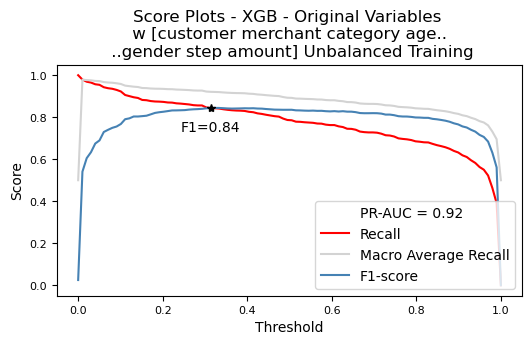

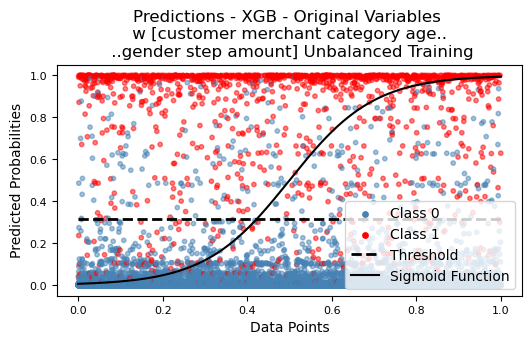

######### XGB - Original Variables - w [customer merchant category age.. - ..gender step amount] Unbalanced Training #########
Confusion Matrix - Optimal Threshold = 0.313

     0    1
117208  234
   232 1255

Classification Report - Optimal Threshold = 0.313

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117442
           1       0.84      0.84      0.84      1487

    accuracy                           1.00    118929
   macro avg       0.92      0.92      0.92    118929
weighted avg       1.00      1.00      1.00    118929



In [25]:
title = f'- XGB - Original Variables \n w [customer merchant category age.. \n ..gender step amount] Unbalanced Training'
full_class_report(y_test, ypred_xgb, title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  sample0=1,
                  criterion='f1_recall_diff',
                  legend_loc='lower right', save_plot=True)

In [ ]:
_, pr_auc_xgb_original, recall_xgb_original, f1_xgb_original, recall_macro_xgb_original = (
    classification_plots(y_test, ypred_xgb, l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [27]:
print(f'pr_auc_xgb_original: {pr_auc_xgb_original},\nrecall_xgb_original: {recall_xgb_original},\nf1_xgb_original: {f1_xgb_original},\nrecall_macro_xgb_original: {recall_macro_xgb_original},')

pr_auc_xgb_original: 0.9191111317980457,
recall_xgb_original: 0.843981170141224,
f1_xgb_original: 0.8434139784946237,
recall_macro_xgb_original: 0.9209943486304969,


In [28]:
beset_recall_xgb_original = best_recall_thresh(y_test, ypred_xgb, 'xgb_original', l_lim=0, u_lim=1, num_thresh=1000)
print(beset_recall_xgb_original)

{'fp_xgb_original': 4638, 'fn_xgb_original': 8, 'thresh_xgb_original': 0.005005005005005005}


In [230]:
beset_recall_xgb_original = best_recall_thresh(y_test, ypred_xgb, 'xgb_original', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_xgb_original)

In [231]:
scr_xgb_original = {
    'pr_auc_xgb_original': pr_auc_xgb_original,
    'recall_xgb_original': recall_xgb_original,
    'f1_xgb_original': f1_xgb_original,
    'recall_macro_xgb_original': recall_macro_xgb_original
}
scores_plot.update(scr_xgb_original)

# (2) All Original Variables - Train on 10% of training data

## Ridge - Original variables - Train on 10% of training data

In [195]:
data_new_reduced = data_new.copy()
data_temp = data_new_reduced[['customer', 'merchant', 'category', 'age', 'gender', 'step', 'amount', 'fraud']].sample(frac=1, random_state=0)

# [['merchant', 'category', 'age', 'gender', 'step', 'amount', 'fraud']]

data3, X, y = one_hot_encode_pandas(data_temp, response='fraud', except_col=['fraud'], drop_first=False)
X_trains, X_test, y_trains, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [196]:
X_train = X_trains.reset_index(drop=True).sample(frac=0.1, random_state=0)
y_train = y_trains.reset_index(drop=True).sample(frac=0.1, random_state=0)

Original Labels
['customer', 'merchant', 'category', 'age', 'gender', 'step', 'amount']

Group Numbers (Groups used for plotting purposes not for regularization)
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

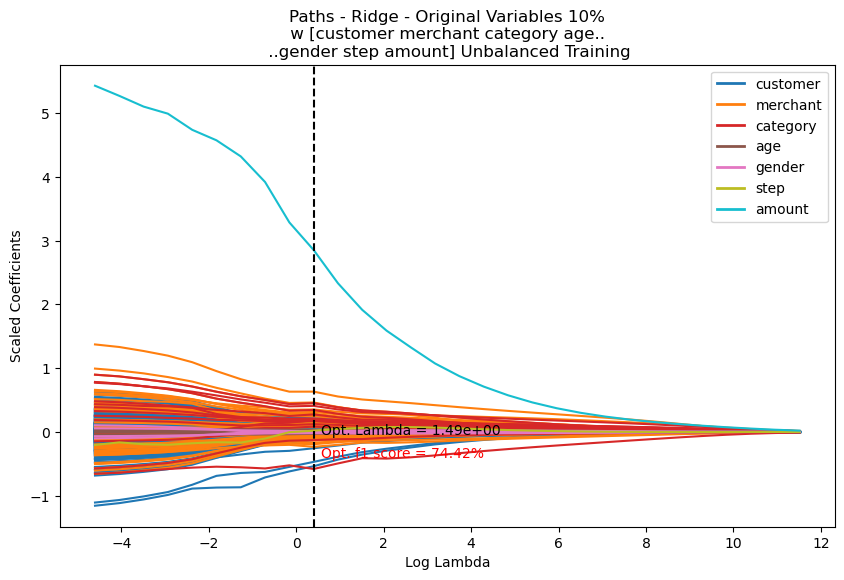

In [197]:
title = f'- Ridge - Original Variables 10%\n w [customer merchant category age.. \n ..gender step amount] Unbalanced Training'
original_labels = data_temp.drop(columns=['fraud']).columns.tolist()
model_r, coefs_r, lam_r, ypred_r, group_lass_labels, labels, scores_r = (
    ridge_paths(X_train, y_train, X_test, original_labels,
                c_start=-5, c_stop=2, c_num=30,
                scoring='f1',
                n_iter=100,
                tol=1e-3,
                cmap='tab10',
                title=title,
                verbose=True,
                save_plot=False))

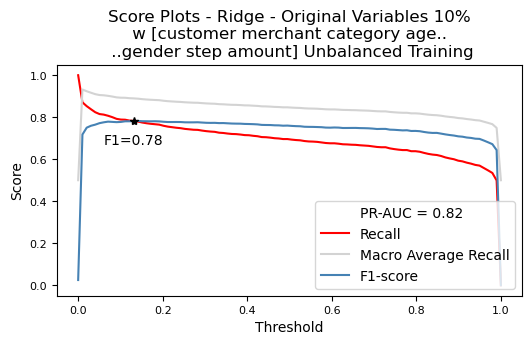

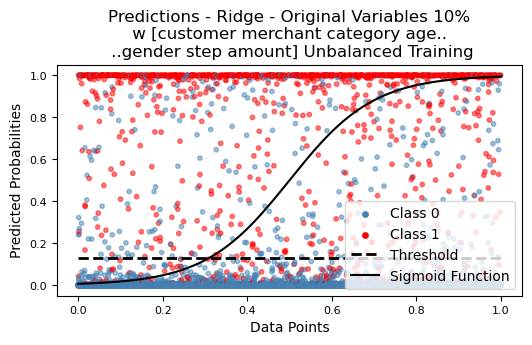

######### Ridge - Original Variables 10%- w [customer merchant category age.. - ..gender step amount] Unbalanced Training #########
Confusion Matrix - Optimal Threshold = 0.131

     0    1
117113  329
   324 1163

Classification Report - Optimal Threshold = 0.131

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117442
           1       0.78      0.78      0.78      1487

    accuracy                           0.99    118929
   macro avg       0.89      0.89      0.89    118929
weighted avg       0.99      0.99      0.99    118929



In [198]:
full_class_report(y_test, ypred_r, title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  criterion='f1_recall_diff',
                  sample0=1,
                  legend_loc='lower right', save_plot=False)

In [ ]:
_, pr_auc_r_original_frac, recall_r_original_frac, f1_r_original_frac, recall_macro_r_original_frac = (
    classification_plots(y_test, ypred_r, l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [200]:
print(f'pr_auc_r_original_frac: {pr_auc_r_original_frac},\nrecall_r_original_frac: {recall_r_original_frac},\nf1_r_original_frac: {f1_r_original_frac},\nrecall_macro_r_original_frac: {recall_macro_r_original_frac},')

pr_auc_r_original_frac: 0.8230604254702848,
recall_r_original_frac: 0.7821116341627438,
f1_r_original_frac: 0.7807989258140315,
recall_macro_r_original_frac: 0.8896551256762528,


In [201]:
beset_recall_r_original_frac = best_recall_thresh(y_test, ypred_r, 'r_original_frac', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_r_original_frac)

In [202]:
scr_r_original_frac = {
    'pr_auc_r_original_frac': pr_auc_r_original_frac,
    'recall_r_original_frac': recall_r_original_frac,
    'f1_r_original_frac': f1_r_original_frac,
    'recall_macro_r_original_frac': recall_macro_r_original_frac
}
scores_plot.update(scr_r_original_frac)

In [42]:
'''file_coef = pd.DataFrame({'cat': X_train.columns,'group_label': group_lass_labels, 'coef': coefs_r.T[:,0]}, index=None)
file_coef.to_csv('data/coefs ridge w-o intercept full training set.csv')'''

## SVM - Original variables - Train on 10% of training data


In [203]:
C = [0.01]
bias = range(1)

svm_values = svm_model(X_train, y_train, X_test, y_test,
                        C, kernel='poly',
                        degree=3,
                        bias=bias,
                        scoring='f1',
                        verbose=True)

1. C = 0.01
    bias: 0
[LibSVM]Optimal Values: f1 score:  0.0236,  C: 0.01,   Bias: 0


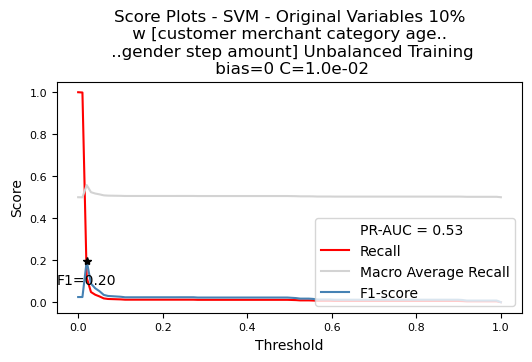

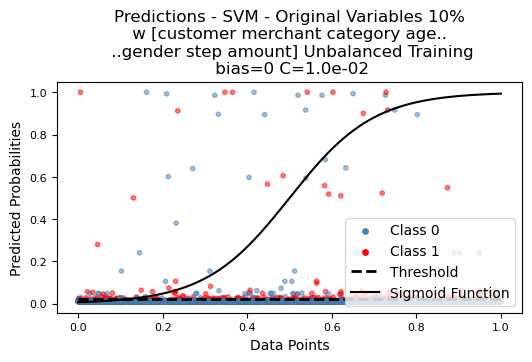

######### SVM - Original Variables 10%- w [customer merchant category age.. - ..gender step amount] Unbalanced Training- bias=0 C=1.0e-02 #########
Confusion Matrix - Optimal Threshold = 0.020

     0   1
117341 101
  1314 173

Classification Report - Optimal Threshold = 0.020

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    117442
           1       0.63      0.12      0.20      1487

    accuracy                           0.99    118929
   macro avg       0.81      0.56      0.60    118929
weighted avg       0.98      0.99      0.98    118929



In [204]:
title=f"- SVM - Original Variables 10%\n w [customer merchant category age.. \n ..gender step amount] Unbalanced Training\n bias={svm_values['bias_opt']} C={svm_values['C_opt']:.1e}"
full_class_report(y_test, svm_values['y_svm'], title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  criterion='f1_recall_diff',
                  sample0=1,
                  legend_loc='lower right', save_plot=False)

In [206]:
print(f'pr_auc_svm_original_frac: {pr_auc_svm_original_frac},\nrecall_svm_original_frac: {recall_svm_original_frac},\nf1_svm_original_frac: {f1_svm_original_frac},\nrecall_macro_svm_original_frac: {recall_macro_svm_original_frac},')

pr_auc_svm_original_frac: 0.5270709474022623,
recall_svm_original_frac: 0.11634162743779422,
f1_svm_original_frac: 0.19647927314026123,
recall_macro_svm_original_frac: 0.5577408142297876,


In [ ]:
_, pr_auc_svm_original_frac, recall_svm_original_frac, f1_svm_original_frac, recall_macro_svm_original_frac = (
    classification_plots(y_test, svm_values['y_svm'], l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [207]:
beset_recall_svm_original_frac = best_recall_thresh(y_test, svm_values['y_svm'], 'svm_original_frac', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_svm_original_frac)

In [208]:
scr_svm_original_frac = {
    'pr_auc_svm_original_frac': pr_auc_svm_original_frac,
    'recall_svm_original_frac': recall_svm_original_frac,
    'f1_svm_original_frac': f1_svm_original_frac,
    'recall_macro_svm_original_frac': recall_macro_svm_original_frac
}
scores_plot.update(scr_svm_original_frac)

## XGB - Original variables - Train on 10% of training data

In [209]:
xgb_model2, ypred_xgb = xgb_logistic_model(X_train, y_train, X_test, y_test, eval_metric='aucpr', max_depth=3, threads=4, iter=50, verbose=True)

[0]	train-aucpr:0.71938	eval-aucpr:0.70544
[1]	train-aucpr:0.77793	eval-aucpr:0.76238
[2]	train-aucpr:0.81189	eval-aucpr:0.78712
[3]	train-aucpr:0.83580	eval-aucpr:0.81370
[4]	train-aucpr:0.85615	eval-aucpr:0.83066
[5]	train-aucpr:0.86547	eval-aucpr:0.83912
[6]	train-aucpr:0.86786	eval-aucpr:0.84235
[7]	train-aucpr:0.87165	eval-aucpr:0.84759
[8]	train-aucpr:0.87540	eval-aucpr:0.85196
[9]	train-aucpr:0.88172	eval-aucpr:0.85745
[10]	train-aucpr:0.88590	eval-aucpr:0.85744
[11]	train-aucpr:0.89073	eval-aucpr:0.85960
[12]	train-aucpr:0.89858	eval-aucpr:0.85931
[13]	train-aucpr:0.90222	eval-aucpr:0.86086
[14]	train-aucpr:0.90541	eval-aucpr:0.85927
[15]	train-aucpr:0.90776	eval-aucpr:0.85569
[16]	train-aucpr:0.90998	eval-aucpr:0.86077
[17]	train-aucpr:0.91259	eval-aucpr:0.86347
[18]	train-aucpr:0.91583	eval-aucpr:0.86402
[19]	train-aucpr:0.91737	eval-aucpr:0.86409
[20]	train-aucpr:0.92221	eval-aucpr:0.86892
[21]	train-aucpr:0.92230	eval-aucpr:0.86760
[22]	train-aucpr:0.92334	eval-aucpr:0.8665

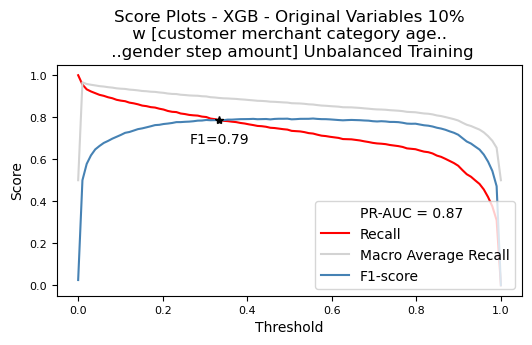

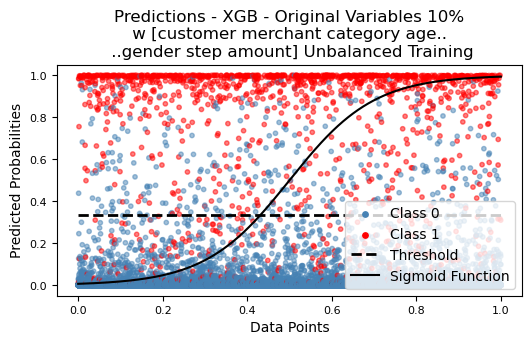

######### XGB - Original Variables 10%- w [customer merchant category age.. - ..gender step amount] Unbalanced Training #########
Confusion Matrix - Optimal Threshold = 0.333

     0    1
117123  319
   318 1169

Classification Report - Optimal Threshold = 0.333

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117442
           1       0.79      0.79      0.79      1487

    accuracy                           0.99    118929
   macro avg       0.89      0.89      0.89    118929
weighted avg       0.99      0.99      0.99    118929



In [210]:
title = f'- XGB - Original Variables 10%\n w [customer merchant category age.. \n ..gender step amount] Unbalanced Training'
full_class_report(y_test, ypred_xgb, title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  sample0=1,
                  criterion='f1_recall_diff',
                  legend_loc='lower right', save_plot=False)

In [ ]:
_, pr_auc_xgb_original_frac, recall_xgb_original_frac, f1_xgb_original_frac, recall_macro_xgb_original_frac = (
    classification_plots(y_test, ypred_xgb, l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [212]:
print(f'pr_auc_xgb_original_frac: {pr_auc_xgb_original_frac},\nrecall_xgb_original_frac: {recall_xgb_original_frac},\nf1_xgb_original_frac: {f1_xgb_original_frac},\nrecall_macro_xgb_original_frac: {recall_macro_xgb_original_frac},')

pr_auc_xgb_original_frac: 0.8717222589742496,
recall_xgb_original_frac: 0.7861466039004708,
f1_xgb_original_frac: 0.7858823529411765,
recall_macro_xgb_original_frac: 0.8917151847519588,


In [213]:
beset_recall_xgb_original_frac = best_recall_thresh(y_test, ypred_xgb, 'xgb_original_frac', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_xgb_original_frac)

In [214]:
scr_xgb_original_frac = {
    'pr_auc_xgb_original_frac': pr_auc_xgb_original_frac,
    'recall_xgb_original_frac': recall_xgb_original_frac,
    'f1_xgb_original_frac': f1_xgb_original_frac,
    'recall_macro_xgb_original_frac': recall_macro_xgb_original_frac
}
scores_plot.update(scr_xgb_original_frac)

# (3) Original Variables, Cust Removed

## Ridge - Original variables, Customer removed

In [33]:
data_new_reduced = data_new.copy()
data_temp = data_new_reduced[['merchant', 'category', 'age', 'gender', 'step', 'amount', 'fraud']].sample(frac=1, random_state=0)

# [['merchant', 'category', 'age', 'gender', 'step', 'amount', 'fraud']]

data3, X, y = one_hot_encode_pandas(data_temp, response='fraud', except_col=['fraud'], drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Original Labels
['merchant', 'category', 'age', 'gender', 'step', 'amount']

Group Numbers (Groups used for plotting purposes not for regularization)
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6]

1/30 lambda: 1.00e+06 - f1 = 0.00%
2/30 lambda: 6.21e+05 - f1 = 0.00%
3/30 lambda: 3.86e+05 - f1 = 0.18%
4/30 lambda: 2.40e+05 - f1 = 2.69%
5/30 lambda: 1.49e+05 - f1 = 5.31%
6/30 lambda: 9.24e+04 - f1 = 10.50%
7/30 lambda: 5.74e+04 - f1 = 34.98%
8/30 lambda: 3.56e+04 - f1 = 51.62%
9/30 lambda: 2.21e+04 - f1 = 60.14%
10/30 lambda: 1.37e+04 - f1 = 65.37%
11/30 lambda: 8.53e+03 - f1 = 69.21%
12/30 lambda: 5.30e+03 - f1 = 72.27%
13/30 lambda: 3.29e+03 - f1 = 74.37%
14/30 lambda: 2.04e+03 - f1 = 76.03%
15/30 lambda: 1.27e+03 - f1 = 77.12%
16/30 lambda: 7.88e+02 - f1 = 78.12%
17/30 lambda: 4.89e+02 - f1 = 78.67%
18/30 la

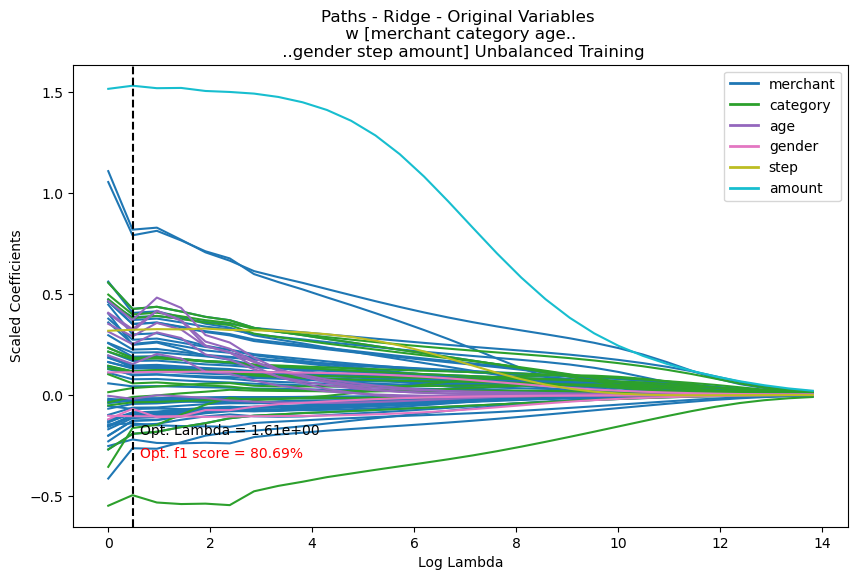

In [34]:
title = f'- Ridge - Original Variables \n w [merchant category age.. \n ..gender step amount] Unbalanced Training'
original_labels = data_temp.drop(columns=['fraud']).columns.tolist()
model_r, coefs_r, lam_r, ypred_r, group_lass_labels, labels, scores_r = (
    ridge_paths(X_train, y_train, X_test, original_labels,
                c_start=-6, c_stop=0, c_num=30,
                scoring='f1',
                n_iter=100,
                tol=1e-3,
                cmap='tab10',
                title=title,
                verbose=True,
                save_plot=False))

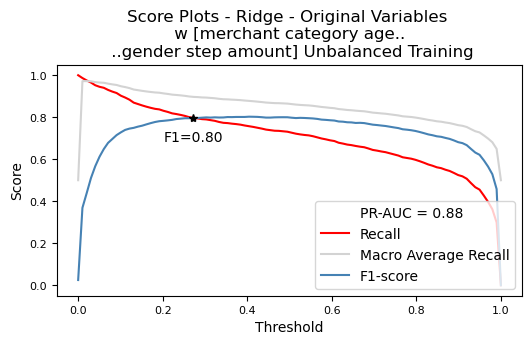

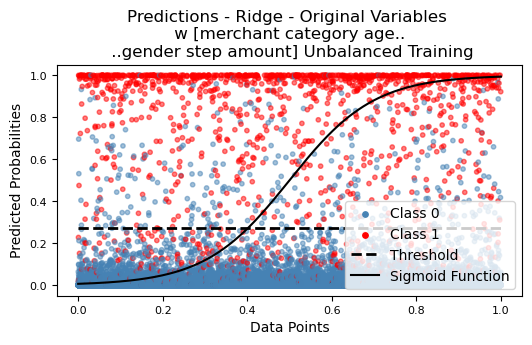

######### Ridge - Original Variables - w [merchant category age.. - ..gender step amount] Unbalanced Training #########
Confusion Matrix - Optimal Threshold = 0.273

     0    1
117135  307
   303 1184

Classification Report - Optimal Threshold = 0.273

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117442
           1       0.79      0.80      0.80      1487

    accuracy                           0.99    118929
   macro avg       0.90      0.90      0.90    118929
weighted avg       0.99      0.99      0.99    118929



In [35]:
full_class_report(y_test, ypred_r, title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  criterion='f1_recall_diff',
                  sample0=1,
                  legend_loc='lower right', save_plot=False)

In [ ]:
_, pr_auc_r_original_c, recall_r_original_c, f1_r_original_c, recall_macro_r_original_c = (
    classification_plots(y_test, ypred_r, l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [37]:
print(f'pr_auc_r_original_c: {pr_auc_r_original_c},\nrecall_r_original_c: {recall_r_original_c},\nf1_r_original_c: {f1_r_original_c},\nrecall_macro_r_original_c: {recall_macro_r_original_c},')

pr_auc_r_original_c: 0.8772504706783465,
recall_r_original_c: 0.7962340282447882,
f1_r_original_c: 0.7951645399597045,
recall_macro_r_original_c: 0.8968099859723285,


In [38]:
beset_recall_r_original_c = best_recall_thresh(y_test, ypred_r, 'r_original_c', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_r_original_c)

In [39]:
scr_r_original_c = {
    'pr_auc_r_original_c': pr_auc_r_original_c,
    'recall_r_original_c': recall_r_original_c,
    'f1_r_original_c': f1_r_original_c,
    'recall_macro_r_original_c': recall_macro_r_original_c
}
scores_plot.update(scr_r_original_c)

## SVM - Original variables, Customer removed

In [40]:
C = [0.01]
bias = range(1)

svm_values = svm_model(X_train, y_train, X_test, y_test,
                        C, kernel='poly',
                        degree=3,
                        bias=bias,
                        scoring='recall_macro',
                        verbose=True)

1. C = 0.01
    bias: 0
[LibSVM]Optimal Values: recall_macro score:  0.8452,  C: 0.01,   Bias: 0


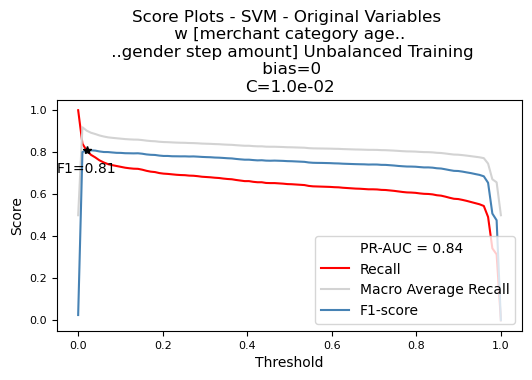

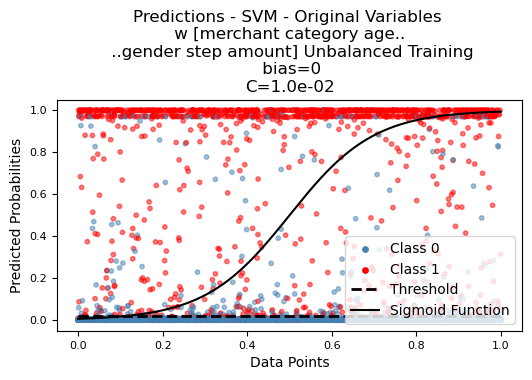

######### SVM - Original Variables - w [merchant category age.. - ..gender step amount] Unbalanced Training- bias=0-C=1.0e-02 #########
Confusion Matrix - Optimal Threshold = 0.020

     0    1
117166  276
   286 1201

Classification Report - Optimal Threshold = 0.020

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117442
           1       0.81      0.81      0.81      1487

    accuracy                           1.00    118929
   macro avg       0.91      0.90      0.90    118929
weighted avg       1.00      1.00      1.00    118929



In [41]:
title=f"- SVM - Original Variables \n w [merchant category age.. \n ..gender step amount] Unbalanced Training\n bias={svm_values['bias_opt']}\nC={svm_values['C_opt']:.1e}"
full_class_report(y_test, svm_values['y_svm'], title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  criterion='f1_recall_diff',
                  sample0=1,
                  legend_loc='lower right', save_plot=False)

In [ ]:
_, pr_auc_svm_original_c, recall_svm_original_c, f1_svm_original_c, recall_macro_svm_original_c = (
    classification_plots(y_test, svm_values['y_svm'], l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [43]:
print(f'pr_auc_svm_original_c = {pr_auc_svm_original_c}\nrecall_svm_original_c = {recall_svm_original_c}\nf1_svm_original_c = {f1_svm_original_c}\nrecall_macro_svm_original_c = {recall_macro_svm_original_c}')

pr_auc_svm_original_c = 0.8398146321541696
recall_svm_original_c = 0.8076664425016813
f1_svm_original_c = 0.810391363022942
recall_macro_svm_original_c = 0.9026581731419869


In [44]:
beset_recall_svm_original_c = best_recall_thresh(y_test, svm_values['y_svm'], 'svm_original_c', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_svm_original_c)

In [45]:
scr_svm_original_c = {
    'pr_auc_svm_original_c': pr_auc_svm_original_c,
    'recall_svm_original_c': recall_svm_original_c,
    'f1_svm_original_c': f1_svm_original_c,
    'recall_macro_svm_original_c': recall_macro_svm_original_c
}
scores_plot.update(scr_svm_original_c)

## XGB - Original variables, Customer removed

In [46]:
xgb_model2, ypred_xgb = xgb_logistic_model(X_train, y_train, X_test, y_test, eval_metric='aucpr', max_depth=3, threads=4, iter=50, verbose=True)

[0]	train-aucpr:0.70828	eval-aucpr:0.68146
[1]	train-aucpr:0.80362	eval-aucpr:0.79044
[2]	train-aucpr:0.84076	eval-aucpr:0.82869
[3]	train-aucpr:0.85340	eval-aucpr:0.84100
[4]	train-aucpr:0.85691	eval-aucpr:0.84457
[5]	train-aucpr:0.80852	eval-aucpr:0.78855
[6]	train-aucpr:0.86019	eval-aucpr:0.84631
[7]	train-aucpr:0.86802	eval-aucpr:0.85764
[8]	train-aucpr:0.85843	eval-aucpr:0.84726
[9]	train-aucpr:0.86177	eval-aucpr:0.85140
[10]	train-aucpr:0.86734	eval-aucpr:0.85553
[11]	train-aucpr:0.87230	eval-aucpr:0.85637
[12]	train-aucpr:0.87531	eval-aucpr:0.86076
[13]	train-aucpr:0.87406	eval-aucpr:0.86029
[14]	train-aucpr:0.87645	eval-aucpr:0.86042
[15]	train-aucpr:0.87686	eval-aucpr:0.86309
[16]	train-aucpr:0.86565	eval-aucpr:0.85437
[17]	train-aucpr:0.86473	eval-aucpr:0.85144
[18]	train-aucpr:0.86760	eval-aucpr:0.85443
[19]	train-aucpr:0.86905	eval-aucpr:0.85583
[20]	train-aucpr:0.82527	eval-aucpr:0.81168
[21]	train-aucpr:0.87097	eval-aucpr:0.85736
[22]	train-aucpr:0.68517	eval-aucpr:0.6684

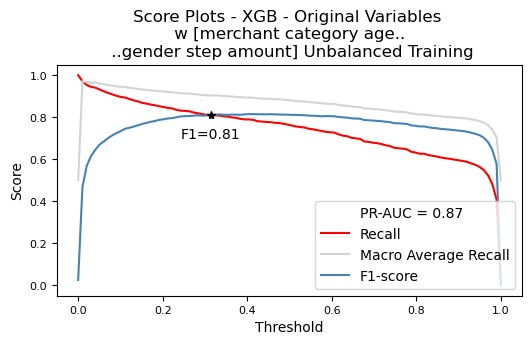

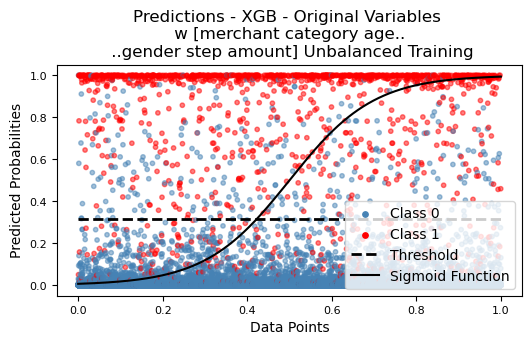

######### XGB - Original Variables - w [merchant category age.. - ..gender step amount] Unbalanced Training #########
Confusion Matrix - Optimal Threshold = 0.313

     0    1
117157  285
   282 1205

Classification Report - Optimal Threshold = 0.313

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117442
           1       0.81      0.81      0.81      1487

    accuracy                           1.00    118929
   macro avg       0.90      0.90      0.90    118929
weighted avg       1.00      1.00      1.00    118929



In [47]:
title = f'- XGB - Original Variables \n w [merchant category age.. \n ..gender step amount] Unbalanced Training'
full_class_report(y_test, ypred_xgb, title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  sample0=1,
                  criterion='f1_recall_diff',
                  legend_loc='lower right', save_plot=False)

In [ ]:
_, pr_auc_xgb_original_c, recall_xgb_original_c, f1_xgb_original_c, recall_macro_xgb_original_c = (
    classification_plots(y_test, ypred_xgb, l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [49]:
print(f'pr_auc_xgb_original_c: {pr_auc_xgb_original_c},\nrecall_xgb_original_c: {recall_xgb_original_c},\nf1_xgb_original_c: {f1_xgb_original_c},\nrecall_macro_xgb_original_c: {recall_macro_xgb_original_c},')

pr_auc_xgb_original_c: 0.8741805724418057,
recall_xgb_original_c: 0.8103564223268326,
f1_xgb_original_c: 0.809539805172993,
recall_macro_xgb_original_c: 0.9039648462684042,


In [50]:
beset_recall_xgb_original_c = best_recall_thresh(y_test, ypred_xgb, 'xgb_original_c', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_xgb_original_c)

In [51]:
scr_xgb_original_c = {
    'pr_auc_xgb_original_c': pr_auc_xgb_original_c,
    'recall_xgb_original_c': recall_xgb_original_c,
    'f1_xgb_original_c': f1_xgb_original_c,
    'recall_macro_xgb_original_c': recall_macro_xgb_original_c
}
scores_plot.update(scr_xgb_original_c)

# (4) Original Variables, Cust , Cat, Merch Removed

## Ridge - Remove large categorical variables Cat, Cust, Merch

In [52]:
data_new_reduced = data_new.copy()
data_temp = data_new_reduced[['age', 'gender', 'step', 'amount', 'fraud']].sample(frac=1, random_state=0)

# [['merchant', 'category', 'age', 'gender', 'step', 'amount', 'fraud']]

data3, X, y = one_hot_encode_pandas(data_temp, response='fraud', except_col=['fraud'], drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Original Labels
['age', 'gender', 'step', 'amount']

Group Numbers (Groups used for plotting purposes not for regularization)
[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 4]

1/30 lambda: 1.00e+06 - f1 = 0.00%
2/30 lambda: 6.72e+05 - f1 = 0.00%
3/30 lambda: 4.52e+05 - f1 = 0.00%
4/30 lambda: 3.04e+05 - f1 = 0.00%
5/30 lambda: 2.04e+05 - f1 = 0.90%
6/30 lambda: 1.37e+05 - f1 = 2.86%
7/30 lambda: 9.24e+04 - f1 = 4.96%
8/30 lambda: 6.21e+04 - f1 = 7.35%
9/30 lambda: 4.18e+04 - f1 = 9.02%
10/30 lambda: 2.81e+04 - f1 = 10.97%
11/30 lambda: 1.89e+04 - f1 = 14.93%
12/30 lambda: 1.27e+04 - f1 = 22.29%
13/30 lambda: 8.53e+03 - f1 = 30.28%
14/30 lambda: 5.74e+03 - f1 = 40.83%
15/30 lambda: 3.86e+03 - f1 = 47.01%
16/30 lambda: 2.59e+03 - f1 = 53.38%
17/30 lambda: 1.74e+03 - f1 = 57.79%
18/30 lambda: 1.17e+03 - f1 = 61.00%
19/30 lambda: 7.88e+02 - f1 = 63.63%
20/30 lambda: 5.30e+02 - f1 = 65.53%
21/30 lambda: 3.56e+02 - f1 = 67.01%
22/30 lambda: 2.40e+02 - f1 = 67.66%
23/30 lambda: 1.61e+02 - f1 = 67.98%
24/

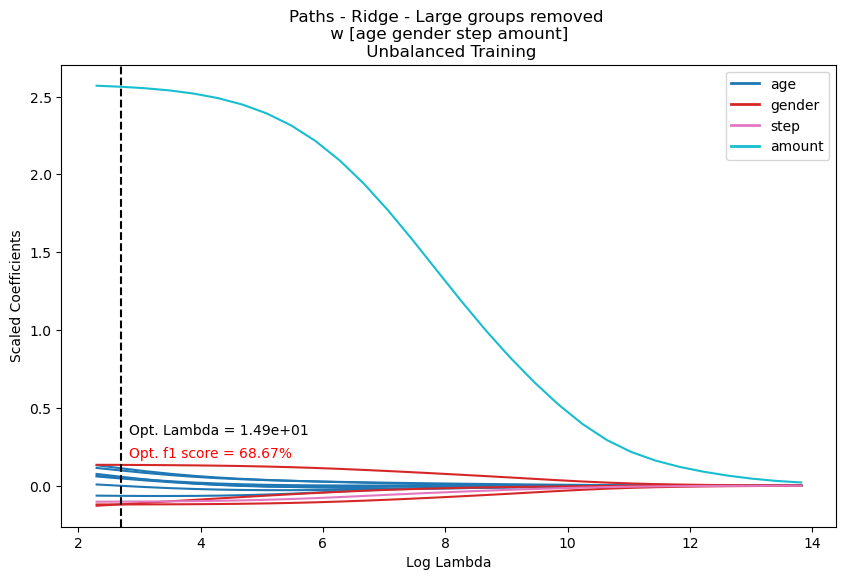

In [53]:
title = f'- Ridge - Large groups removed \n w [age gender step amount] \n Unbalanced Training'
original_labels = data_temp.drop(columns=['fraud']).columns.tolist()
model_r, coefs_r, lam_r, ypred_r, group_lass_labels, labels, scores_r = (
    ridge_paths(X_train, y_train, X_test, original_labels,
                c_start=-6, c_stop=-1, c_num=30,
                scoring='f1',
                n_iter=100,
                tol=1e-3,
                cmap='tab10',
                title=title,
                verbose=True,
                save_plot=False))

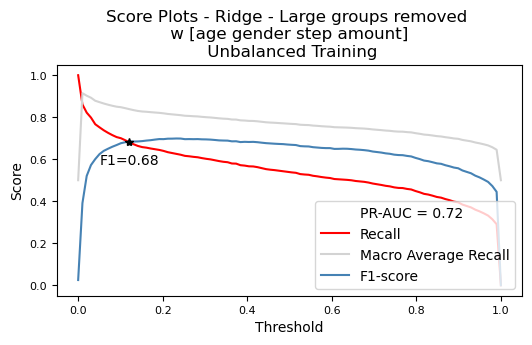

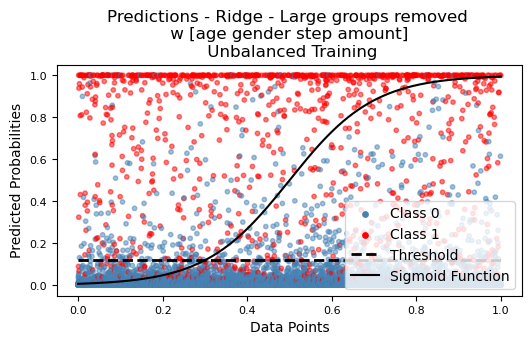

######### Ridge - Large groups removed - w [age gender step amount] - Unbalanced Training #########
Confusion Matrix - Optimal Threshold = 0.121

     0    1
116983  459
   475 1012

Classification Report - Optimal Threshold = 0.121

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117442
           1       0.69      0.68      0.68      1487

    accuracy                           0.99    118929
   macro avg       0.84      0.84      0.84    118929
weighted avg       0.99      0.99      0.99    118929



In [54]:
full_class_report(y_test, ypred_r, title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  criterion='f1_recall_diff',
                  sample0=1,
                  legend_loc='lower right', save_plot=False)

In [ ]:
_, pr_auc_r_nogroup, recall_r_nogroup, f1_r_nogroup, recall_macro_r_nogroup = (
    classification_plots(y_test, ypred_r, l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [56]:
print(f'pr_auc_r_nogroup: {pr_auc_r_nogroup}\nrecall_r_nogroup: {recall_r_nogroup}\nf1_r_nogroup: {f1_r_nogroup}\nrecall_macro_r_nogroup: {recall_macro_r_nogroup}')

pr_auc_r_nogroup: 0.7178074646279751
recall_r_nogroup: 0.6805648957632818
f1_r_nogroup: 0.6842461122379987
recall_macro_r_nogroup: 0.838328291787569


In [57]:
beset_recall_r_nogroup = best_recall_thresh(y_test, ypred_r, 'r_nogroup', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_r_nogroup)

In [58]:
scr_r_nogroup = {
    'pr_auc_r_nogroup': pr_auc_r_nogroup,
    'recall_r_nogroup': recall_r_nogroup,
    'f1_r_nogroup': f1_r_nogroup,
    'recall_macro_r_nogroup': recall_macro_r_nogroup
}
scores_plot.update(scr_r_nogroup)

## SVM - Remove large categorical variables Cat, Cust, Merch

In [59]:
C = [0.01]
bias = range(1)

svm_values = svm_model(X_train, y_train, X_test, y_test,
                        C, kernel='poly',
                        degree=3,
                        bias=bias,
                        scoring='recall_macro',
                        verbose=True)

1. C = 0.01
    bias: 0
[LibSVM]Optimal Values: recall_macro score:  0.6704,  C: 0.01,   Bias: 0


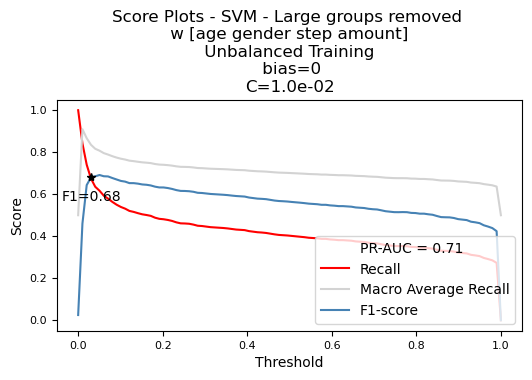

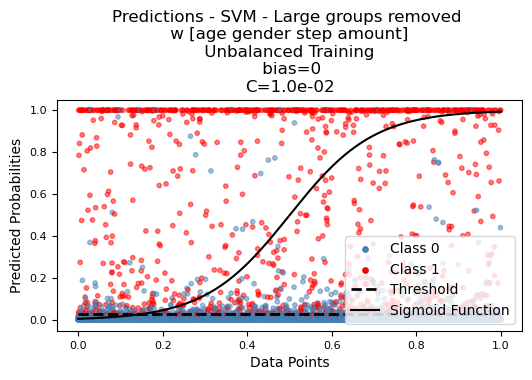

######### SVM - Large groups removed - w [age gender step amount] - Unbalanced Training - bias=0-C=1.0e-02 #########
Confusion Matrix - Optimal Threshold = 0.030

     0    1
116982  460
   484 1003

Classification Report - Optimal Threshold = 0.030

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117442
           1       0.69      0.67      0.68      1487

    accuracy                           0.99    118929
   macro avg       0.84      0.84      0.84    118929
weighted avg       0.99      0.99      0.99    118929



In [60]:
title=f"- SVM - Large groups removed \n w [age gender step amount] \n Unbalanced Training \n bias={svm_values['bias_opt']}\nC={svm_values['C_opt']:.1e}"
full_class_report(y_test, svm_values['y_svm'], title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  criterion='f1_recall_diff',
                  sample0=1,
                  legend_loc='lower right', save_plot=False)

In [ ]:
_, pr_auc_svm_nogroup, recall_svm_nogroup, f1_svm_nogroup, recall_macro_svm_nogroup = (
    classification_plots(y_test, svm_values['y_svm'], l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [62]:
print(f'pr_auc_svm_nogroup: {pr_auc_svm_nogroup}\nrecall_svm_nogroup: {recall_svm_nogroup}\nf1_svm_nogroup: {f1_svm_nogroup}\nrecall_macro_svm_nogroup: {recall_macro_svm_nogroup}')

pr_auc_svm_nogroup: 0.7128365740429073
recall_svm_nogroup: 0.6745124411566913
f1_svm_nogroup: 0.6799999999999999
recall_macro_svm_nogroup: 0.8352978070635895


In [63]:
beset_recall_svm_nogroup = best_recall_thresh(y_test, svm_values['y_svm'], 'svm_nogroup', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_svm_nogroup)

In [64]:
scr_svm_nogroup = {
    'pr_auc_svm_nogroup': pr_auc_svm_nogroup,
    'recall_svm_nogroup': recall_svm_nogroup,
    'f1_svm_nogroup': f1_svm_nogroup,
    'recall_macro_svm_nogroup': recall_macro_svm_nogroup
}
scores_plot.update(scr_svm_nogroup)

## XGB - Remove large categorical variables Cat, Cust, Merch

In [65]:
xgb_model0, ypred_xgb = xgb_logistic_model(X_train, y_train, X_test, y_test, eval_metric='aucpr', max_depth=3, threads=4, iter=10, verbose=True)

[0]	train-aucpr:0.70644	eval-aucpr:0.70317
[1]	train-aucpr:0.71668	eval-aucpr:0.71424
[2]	train-aucpr:0.72346	eval-aucpr:0.72048
[3]	train-aucpr:0.72508	eval-aucpr:0.71760
[4]	train-aucpr:0.72929	eval-aucpr:0.72591
[5]	train-aucpr:0.73004	eval-aucpr:0.72795
[6]	train-aucpr:0.72997	eval-aucpr:0.72859
[7]	train-aucpr:0.73212	eval-aucpr:0.73022
[8]	train-aucpr:0.73237	eval-aucpr:0.73023
[9]	train-aucpr:0.73287	eval-aucpr:0.73079


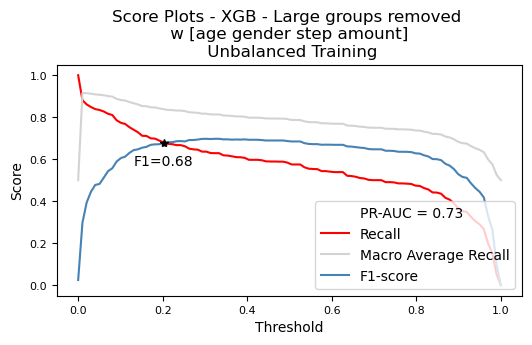

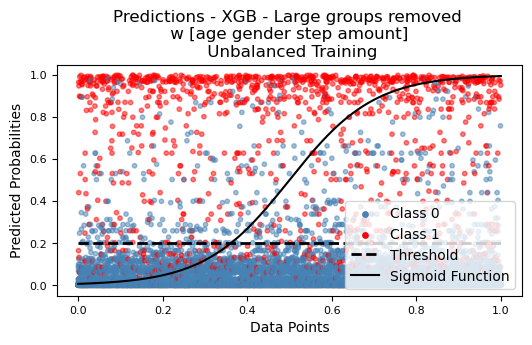

######### XGB - Large groups removed - w [age gender step amount] - Unbalanced Training #########
Confusion Matrix - Optimal Threshold = 0.202

     0    1
116960  482
   475 1012

Classification Report - Optimal Threshold = 0.202

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117442
           1       0.68      0.68      0.68      1487

    accuracy                           0.99    118929
   macro avg       0.84      0.84      0.84    118929
weighted avg       0.99      0.99      0.99    118929



In [66]:
title = f'- XGB - Large groups removed \n w [age gender step amount] \n Unbalanced Training'
full_class_report(y_test, ypred_xgb, title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  sample0=1,
                  criterion='f1_recall_diff',
                  legend_loc='lower right', save_plot=False)

In [ ]:
_, pr_auc_xgb_nogroup, recall_xgb_nogroup, f1_xgb_nogroup, recall_macro_xgb_nogroup = (
    classification_plots(y_test, ypred_xgb, l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [68]:
print(f'pr_auc_xgb_nogroup: {pr_auc_xgb_nogroup}\nrecall_xgb_nogroup: {recall_xgb_nogroup}\nf1_xgb_nogroup: {f1_xgb_nogroup}\nrecall_macro_xgb_nogroup: {recall_macro_xgb_nogroup}')

pr_auc_xgb_nogroup: 0.7285126628149565
recall_xgb_nogroup: 0.6805648957632818
f1_xgb_nogroup: 0.6789667896678968
recall_macro_xgb_nogroup: 0.8382303711118311


In [69]:
beset_recall_xgb_nogroup = best_recall_thresh(y_test, ypred_xgb, 'xgb_nogroup', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_xgb_nogroup)

In [70]:
scr_xgb_nogroup = {
    'pr_auc_xgb_nogroup': pr_auc_xgb_nogroup,
    'recall_xgb_nogroup': recall_xgb_nogroup,
    'f1_xgb_nogroup': f1_xgb_nogroup,
    'recall_macro_xgb_nogroup': recall_macro_xgb_nogroup
}
scores_plot.update(scr_xgb_nogroup)

# (5) Cust, Cat, Merch Grouped Based on Amount Spent

## Ridge - groups based on amount spent

In [50]:
data_new_reduced = data_new.copy()
data_temp = data_new_reduced[['quant_cust_amnt', 'quant_merch_amnt', 'quant_cat_amnt', 'age', 'gender', 'step', 'amount', 'fraud']].sample(frac=1, random_state=0)

# [['merchant', 'category', 'age', 'gender', 'step', 'amount', 'fraud']]

data3, X, y = one_hot_encode_pandas(data_temp, response='fraud', except_col=['fraud'], drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Original Labels
['quant_cust_amnt', 'quant_merch_amnt', 'quant_cat_amnt', 'age', 'gender', 'step', 'amount']

Group Numbers (Groups used for plotting purposes not for regularization)
[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 6, 7]

1/30 lambda: 1.00e+06 - f1 = 0.00%
2/30 lambda: 5.74e+05 - f1 = 0.00%
3/30 lambda: 3.29e+05 - f1 = 0.00%
4/30 lambda: 1.89e+05 - f1 = 1.44%
5/30 lambda: 1.08e+05 - f1 = 4.44%
6/30 lambda: 6.21e+04 - f1 = 8.02%
7/30 lambda: 3.56e+04 - f1 = 12.59%
8/30 lambda: 2.04e+04 - f1 = 21.67%
9/30 lambda: 1.17e+04 - f1 = 36.86%
10/30 lambda: 6.72e+03 - f1 = 48.71%
11/30 lambda: 3.86e+03 - f1 = 57.92%
12/30 lambda: 2.21e+03 - f1 = 63.38%
13/30 lambda: 1.27e+03 - f1 = 68.36%
14/30 lambda: 7.28e+02 - f1 = 71.52%
15/30 lambda: 4.18e+02 - f1 = 72.89%
16/30 lambda: 2.40e+02 - f1 = 73.76%
17/30 lambda: 1.37e+02 - f1 = 74.69%
18/30 lambda: 7.88e+01 - f1 = 74.85%
19/30 lambda: 4.52e+01 - f1 = 75.04%
20/30 lambda: 2.59e+01 - f1 

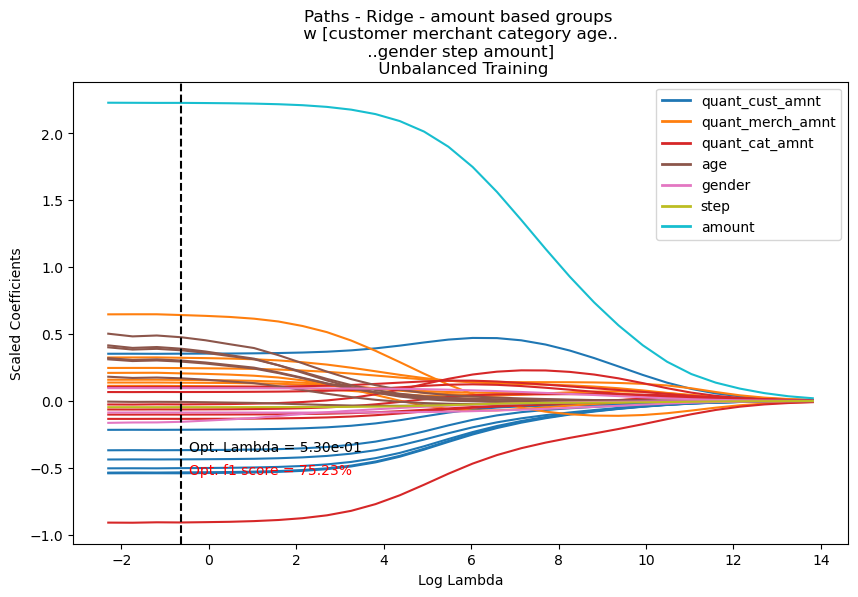

In [69]:
title = f'- Ridge - amount based groups \n w [customer merchant category age.. \n ..gender step amount] \n Unbalanced Training'
original_labels = data_temp.drop(columns=['fraud']).columns.tolist()
model_r, coefs_r, lam_r, ypred_r, group_lass_labels, labels, scores_r = (
    ridge_paths(X_train, y_train, X_test, original_labels,
                c_start=-6, c_stop=1, c_num=30,
                scoring='f1',
                n_iter=100,
                tol=1e-3,
                cmap='tab10',
                title=title,
                verbose=True,
                save_plot=False))

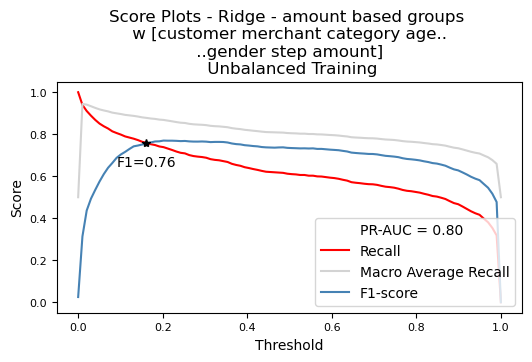

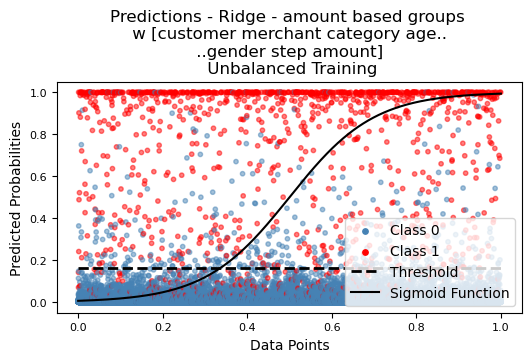

######### Ridge - amount based groups - w [customer merchant category age.. - ..gender step amount] - Unbalanced Training #########
Confusion Matrix - Optimal Threshold = 0.162

     0    1
117078  364
   359 1128

Classification Report - Optimal Threshold = 0.162

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117442
           1       0.76      0.76      0.76      1487

    accuracy                           0.99    118929
   macro avg       0.88      0.88      0.88    118929
weighted avg       0.99      0.99      0.99    118929



In [67]:
full_class_report(y_test, ypred_r, title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  criterion='f1_recall_diff',
                  sample0=1,
                  legend_loc='lower right', save_plot=False)

In [ ]:
_, pr_auc_r_amount, recall_r_amount, f1_r_amount, recall_macro_r_amount = (
    classification_plots(y_test, ypred_r, l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [54]:
print(f'pr_auc_r_amount: {pr_auc_r_amount},\nrecall_r_amount: {recall_r_amount},\nf1_r_amount: {f1_r_amount},\nrecall_macro_r_amount: {recall_macro_r_amount},')

pr_auc_r_amount: 0.7960534909329869,
recall_r_amount: 0.7585743106926698,
f1_r_amount: 0.75730110775428,
recall_macro_r_amount: 0.8777374542172669,


In [55]:
beset_recall_r_amount = best_recall_thresh(y_test, ypred_r, 'r_amount', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_r_amount)

In [56]:
scr_r_amount = {
    'pr_auc_r_amount': pr_auc_r_amount,
    'recall_r_amount': recall_r_amount,
    'f1_r_amount': f1_r_amount,
    'recall_macro_r_amount': recall_macro_r_amount
}
scores_plot.update(scr_r_amount)

## SVM - groups based on amount spent

In [58]:
C = [0.01]
bias = range(1)

svm_values = svm_model(X_train, y_train, X_test, y_test,
                        C, kernel='poly',
                        degree=3,
                        bias=bias,
                        scoring='recall_macro',
                        verbose=True)

1. C = 0.01
    bias: 0
[LibSVM]Optimal Values: recall_macro score:  0.7634,  C: 0.01,   Bias: 0


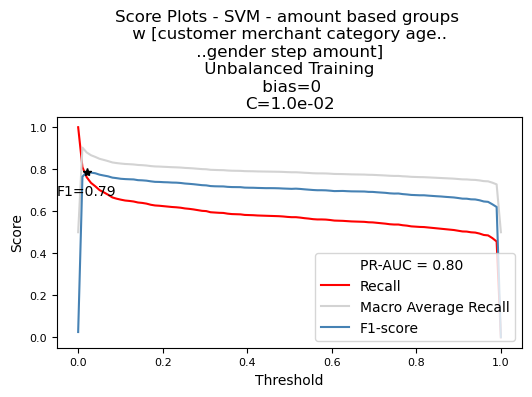

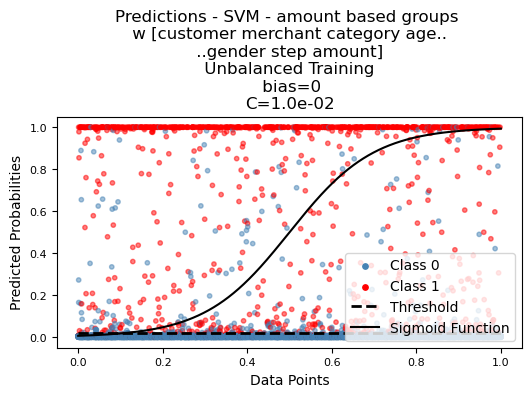

######### SVM - amount based groups - w [customer merchant category age.. - ..gender step amount] - Unbalanced Training - bias=0-C=1.0e-02 #########
Confusion Matrix - Optimal Threshold = 0.020

     0    1
117180  262
   354 1133

Classification Report - Optimal Threshold = 0.020

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117442
           1       0.81      0.76      0.79      1487

    accuracy                           0.99    118929
   macro avg       0.90      0.88      0.89    118929
weighted avg       0.99      0.99      0.99    118929



In [59]:
title=f"- SVM - amount based groups \n w [customer merchant category age.. \n ..gender step amount] \n Unbalanced Training \n bias={svm_values['bias_opt']}\nC={svm_values['C_opt']:.1e}"
full_class_report(y_test, svm_values['y_svm'], title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  criterion='f1_recall_diff',
                  sample0=1,
                  legend_loc='lower right', save_plot=True)

In [ ]:
_, pr_auc_svm_amount, recall_svm_amount, f1_svm_amount, recall_macro_svm_amount = (
    classification_plots(y_test, svm_values['y_svm'], l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [70]:
print(f"'pr_auc_svm_amount': {pr_auc_svm_amount},\n'recall_svm_amount': {recall_svm_amount},\n'f1_svm_amount': {f1_svm_amount},\n'recall_macro_svm_amount': {recall_macro_svm_amount},")

'pr_auc_svm_amount': 0.7996996932391469,
'recall_svm_amount': 0.7619367854741089,
'f1_svm_amount': 0.7862595419847328,
'recall_macro_svm_amount': 0.8798529485177803,


In [71]:
beset_recall_svm_amount = best_recall_thresh(y_test, svm_values['y_svm'], 'svm_amount', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_svm_amount)

In [83]:
scr_svm_amount = {
    'pr_auc_svm_amount': pr_auc_svm_amount,
    'recall_svm_amount': recall_svm_amount,
    'f1_svm_amount': f1_svm_amount,
    'recall_macro_svm_amount': recall_macro_svm_amount
}
scores_plot.update(scr_svm_amount)

## XGB - groups based on amount spent

In [63]:
xgb_model, ypred_xgb = xgb_logistic_model(X_train, y_train, X_test, y_test, max_depth=3, eval_metric='aucpr', threads=4, iter=25, verbose=True)

[0]	train-aucpr:0.72197	eval-aucpr:0.71802
[1]	train-aucpr:0.75178	eval-aucpr:0.75305
[2]	train-aucpr:0.78103	eval-aucpr:0.78304
[3]	train-aucpr:0.79698	eval-aucpr:0.80518
[4]	train-aucpr:0.80012	eval-aucpr:0.80641
[5]	train-aucpr:0.80674	eval-aucpr:0.81304
[6]	train-aucpr:0.81218	eval-aucpr:0.81916
[7]	train-aucpr:0.81364	eval-aucpr:0.81946
[8]	train-aucpr:0.81638	eval-aucpr:0.82220
[9]	train-aucpr:0.82295	eval-aucpr:0.82718
[10]	train-aucpr:0.82677	eval-aucpr:0.82875
[11]	train-aucpr:0.82802	eval-aucpr:0.82858
[12]	train-aucpr:0.83174	eval-aucpr:0.83373
[13]	train-aucpr:0.83435	eval-aucpr:0.83699
[14]	train-aucpr:0.83614	eval-aucpr:0.83902
[15]	train-aucpr:0.83900	eval-aucpr:0.84043
[16]	train-aucpr:0.84093	eval-aucpr:0.84364
[17]	train-aucpr:0.84481	eval-aucpr:0.84717
[18]	train-aucpr:0.84563	eval-aucpr:0.84783
[19]	train-aucpr:0.84709	eval-aucpr:0.84883
[20]	train-aucpr:0.84759	eval-aucpr:0.84815
[21]	train-aucpr:0.84867	eval-aucpr:0.84841
[22]	train-aucpr:0.85107	eval-aucpr:0.8504

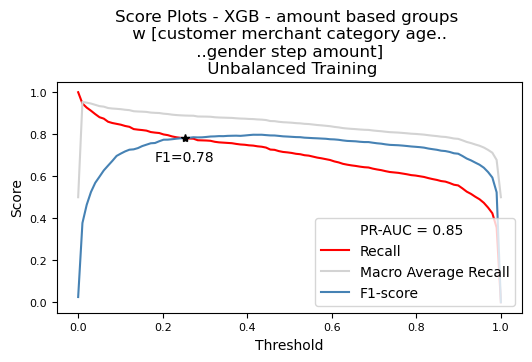

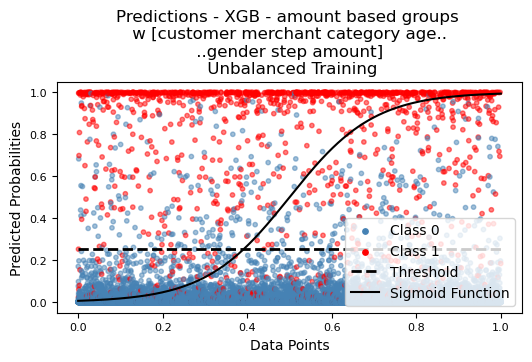

######### XGB - amount based groups - w [customer merchant category age.. - ..gender step amount] - Unbalanced Training #########
Confusion Matrix - Optimal Threshold = 0.253

     0    1
117117  325
   326 1161

Classification Report - Optimal Threshold = 0.253

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117442
           1       0.78      0.78      0.78      1487

    accuracy                           0.99    118929
   macro avg       0.89      0.89      0.89    118929
weighted avg       0.99      0.99      0.99    118929



In [73]:
title = f'- XGB - amount based groups \n w [customer merchant category age.. \n ..gender step amount] \n Unbalanced Training'
full_class_report(y_test, ypred_xgb, title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  sample0=1,
                  criterion='f1_recall_diff',
                  legend_loc='lower right', save_plot=False)

In [ ]:
_, pr_auc_xgb_amount, recall_xgb_amount, f1_xgb_amount, recall_macro_xgb_amount = (
    classification_plots(y_test, ypred_xgb, l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [75]:
print(f"'pr_auc_xgb_amount': {pr_auc_xgb_amount},\n'recall_xgb_amount': {recall_xgb_amount},\n'f1_xgb_amount': {f1_xgb_amount},\n'recall_macro_xgb_amount': {recall_macro_xgb_amount},")

'pr_auc_xgb_amount': 0.8506320866397049,
'recall_xgb_amount': 0.7807666442501682,
'f1_xgb_amount': 0.7810292633703331,
'recall_macro_xgb_amount': 0.888999660402702,


In [76]:
beset_recall_xgb_amount = best_recall_thresh(y_test, ypred_xgb, 'xgb_amount', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_xgb_amount)

In [89]:
scr_xgb_amount = {
    'pr_auc_xgb_amount': pr_auc_xgb_amount,
    'recall_xgb_amount': recall_xgb_amount,
    'f1_xgb_amount': f1_xgb_amount,
    'recall_macro_xgb_amount': recall_macro_xgb_amount
}
scores_plot.update(scr_xgb_amount)

# (6) Cust, Cat, Merch Grouped Based on Coefs

## Ridge - groups based on regression coefs

In [90]:
data_new_reduced = data_new.copy()
data_temp = data_new_reduced[['quant_cust_coef', 'quant_merch_coef', 'quant_cat_coef', 'age', 'gender', 'step', 'amount', 'fraud']].sample(frac=1, random_state=0)

# [['merchant', 'category', 'age', 'gender', 'step', 'amount', 'fraud']]

data3, X, y = one_hot_encode_pandas(data_temp, response='fraud', except_col=['fraud'], drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Original Labels
['quant_cust_coef', 'quant_merch_coef', 'quant_cat_coef', 'age', 'gender', 'step', 'amount']

Group Numbers (Groups used for plotting purposes not for regularization)
[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 6, 7]

1/30 lambda: 1.00e+06 - f1 = 0.00%
2/30 lambda: 6.21e+05 - f1 = 0.00%
3/30 lambda: 3.86e+05 - f1 = 0.00%
4/30 lambda: 2.40e+05 - f1 = 0.90%
5/30 lambda: 1.49e+05 - f1 = 4.09%
6/30 lambda: 9.24e+04 - f1 = 8.36%
7/30 lambda: 5.74e+04 - f1 = 15.23%
8/30 lambda: 3.56e+04 - f1 = 22.86%
9/30 lambda: 2.21e+04 - f1 = 33.01%
10/30 lambda: 1.37e+04 - f1 = 46.32%
11/30 lambda: 8.53e+03 - f1 = 58.45%
12/30 lambda: 5.30e+03 - f1 = 64.80%
13/30 lambda: 3.29e+03 - f1 = 70.36%
14/30 lambda: 2.04e+03 - f1 = 74.39%
15/30 lambda: 1.27e+03 - f1 = 77.80%
16/30 lambda: 7.88e+02 - f1 = 79.55%
17/30 lambda: 4.89e+02 - f1 = 80.57%
18/30 lambda: 3.04e+02 - f1 = 81.38%
19/30 lambda: 1.89e+02 - f1 = 81.90%
20/30 lambda: 1.17e+02 - f1 = 82.21%
21/30 lam

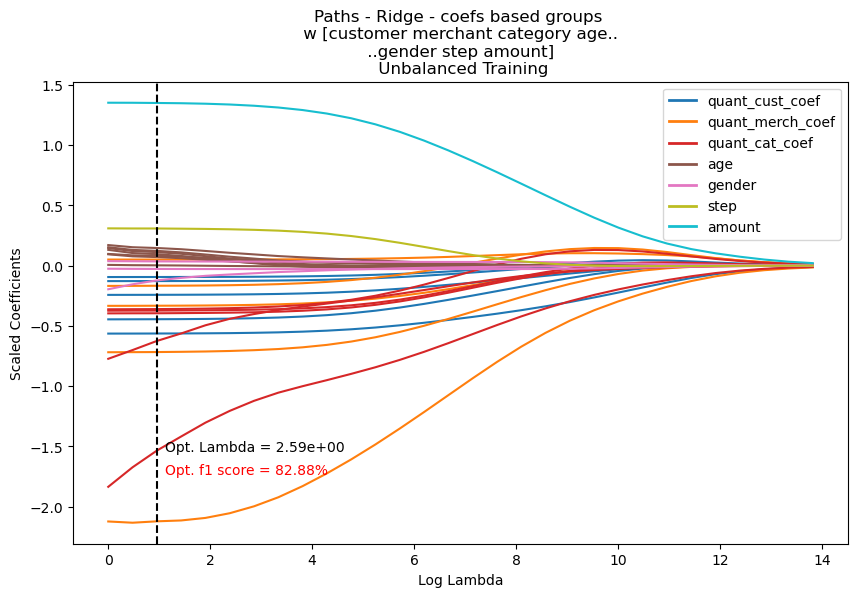

In [91]:
title = f'- Ridge - coefs based groups \n w [customer merchant category age.. \n ..gender step amount] \n Unbalanced Training'
original_labels = data_temp.drop(columns=['fraud']).columns.tolist()
model_r, coefs_r, lam_r, ypred_r, group_lass_labels, labels, scores_r = (
    ridge_paths(X_train, y_train, X_test, original_labels,
                c_start=-6, c_stop=0, c_num=30,
                scoring='f1',
                n_iter=100,
                tol=1e-3,
                cmap='tab10',
                title=title,
                verbose=True,
                save_plot=False))

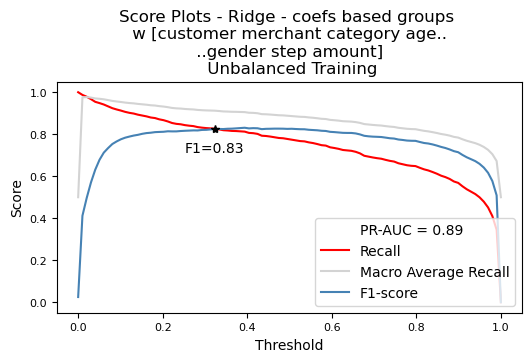

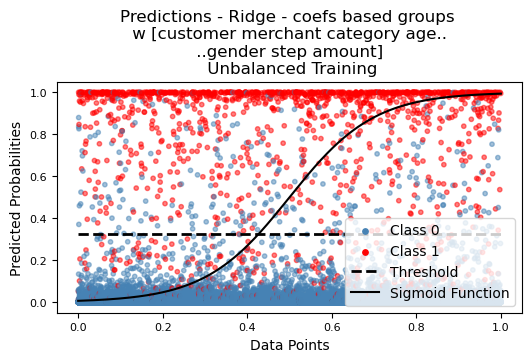

######### Ridge - coefs based groups - w [customer merchant category age.. - ..gender step amount] - Unbalanced Training #########
Confusion Matrix - Optimal Threshold = 0.323

     0    1
117179  263
   258 1229

Classification Report - Optimal Threshold = 0.323

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117442
           1       0.82      0.83      0.83      1487

    accuracy                           1.00    118929
   macro avg       0.91      0.91      0.91    118929
weighted avg       1.00      1.00      1.00    118929



In [92]:
full_class_report(y_test, ypred_r, title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  criterion='f1_recall_diff',
                  sample0=1,
                  legend_loc='lower right', save_plot=False)

In [ ]:
_, pr_auc_r_coef, recall_r_coef, f1_r_coef, recall_macro_r_coef = (
    classification_plots(y_test, ypred_r, l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [94]:
print(f'pr_auc_r_coef: {pr_auc_r_coef},\nrecall_r_coef: {recall_r_coef},\nf1_r_coef: {f1_r_coef},\nrecall_macro_r_coef: {recall_macro_r_coef},')

pr_auc_r_coef: 0.8928035374681783,
recall_r_coef: 0.8264963012777404,
f1_r_coef: 0.8251090970124203,
recall_macro_r_coef: 0.9121284489989118,


In [95]:
beset_recall_r_coef = best_recall_thresh(y_test, ypred_r, 'r_coef', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_r_coef)

In [96]:
scr_r_coef = {
    'pr_auc_r_coef': pr_auc_r_coef,
    'recall_r_coef': recall_r_coef,
    'f1_r_coef': f1_r_coef,
    'recall_macro_r_coef': recall_macro_r_coef
}
scores_plot.update(scr_r_coef)

## SVM - groups based on regression coefs

In [97]:
C = [0.01]
bias = range(1)

svm_values = svm_model(X_train, y_train, X_test, y_test,
                        C, kernel='poly',
                        degree=3,
                        bias=bias,
                        scoring='recall_macro',
                        verbose=True)

1. C = 0.01
    bias: 0
[LibSVM]Optimal Values: recall_macro score:  0.8684,  C: 0.01,   Bias: 0


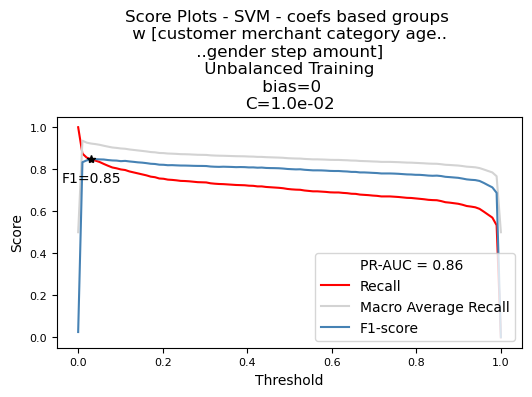

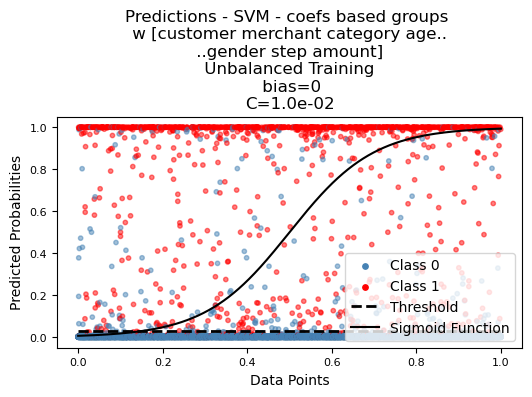

######### SVM - coefs based groups - w [customer merchant category age.. - ..gender step amount] - Unbalanced Training - bias=0-C=1.0e-02 #########
Confusion Matrix - Optimal Threshold = 0.030

     0    1
117214  228
   228 1259

Classification Report - Optimal Threshold = 0.030

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117442
           1       0.85      0.85      0.85      1487

    accuracy                           1.00    118929
   macro avg       0.92      0.92      0.92    118929
weighted avg       1.00      1.00      1.00    118929



In [98]:
title=f"- SVM - coefs based groups \n w [customer merchant category age.. \n ..gender step amount] \n Unbalanced Training \n bias={svm_values['bias_opt']}\nC={svm_values['C_opt']:.1e}"
full_class_report(y_test, svm_values['y_svm'], title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  criterion='f1_recall_diff',
                  sample0=1,
                  legend_loc='lower right', save_plot=False)

In [ ]:
_, pr_auc_svm_coef, recall_svm_coef, f1_svm_coef, recall_macro_svm_coef = (
    classification_plots(y_test, svm_values['y_svm'], l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [100]:
print(f'pr_auc_svm_coef: {pr_auc_svm_coef}\nrecall_svm_coef: {recall_svm_coef}\nf1_svm_coef: {f1_svm_coef}\nrecall_macro_svm_coef: {recall_macro_svm_coef}')

pr_auc_svm_coef: 0.8620969203479943
recall_svm_coef: 0.8466711499663753
f1_svm_coef: 0.8466711499663753
recall_macro_svm_coef: 0.922364883067178


In [101]:
beset_recall_svm_coef = best_recall_thresh(y_test, svm_values['y_svm'], 'svm_coef', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_svm_coef)

In [102]:
scr_svm_coef = {
    'pr_auc_svm_coef': pr_auc_svm_coef,
    'recall_svm_coef': recall_svm_coef,
    'f1_svm_coef': f1_svm_coef,
    'recall_macro_svm_coef': recall_macro_svm_coef
}
scores_plot.update(scr_svm_coef)

## XGB - groups based on regression coefs

In [103]:
xgb_model2, ypred_xgb = xgb_logistic_model(X_train, y_train, X_test, y_test, max_depth=3, eval_metric='aucpr', threads=4, iter=30, verbose=True)

[0]	train-aucpr:0.74616	eval-aucpr:0.75123
[1]	train-aucpr:0.80592	eval-aucpr:0.80978
[2]	train-aucpr:0.83873	eval-aucpr:0.84507
[3]	train-aucpr:0.86080	eval-aucpr:0.86210
[4]	train-aucpr:0.87487	eval-aucpr:0.87185
[5]	train-aucpr:0.88347	eval-aucpr:0.88035
[6]	train-aucpr:0.89620	eval-aucpr:0.89141
[7]	train-aucpr:0.90289	eval-aucpr:0.89467
[8]	train-aucpr:0.90999	eval-aucpr:0.89894
[9]	train-aucpr:0.91578	eval-aucpr:0.90395
[10]	train-aucpr:0.91797	eval-aucpr:0.90859
[11]	train-aucpr:0.91953	eval-aucpr:0.90874
[12]	train-aucpr:0.92271	eval-aucpr:0.91125
[13]	train-aucpr:0.92561	eval-aucpr:0.91247
[14]	train-aucpr:0.92649	eval-aucpr:0.91265
[15]	train-aucpr:0.92737	eval-aucpr:0.91260
[16]	train-aucpr:0.92995	eval-aucpr:0.91617
[17]	train-aucpr:0.93062	eval-aucpr:0.91661
[18]	train-aucpr:0.93150	eval-aucpr:0.91667
[19]	train-aucpr:0.93236	eval-aucpr:0.91671
[20]	train-aucpr:0.93268	eval-aucpr:0.91729
[21]	train-aucpr:0.93307	eval-aucpr:0.91719
[22]	train-aucpr:0.93409	eval-aucpr:0.9169

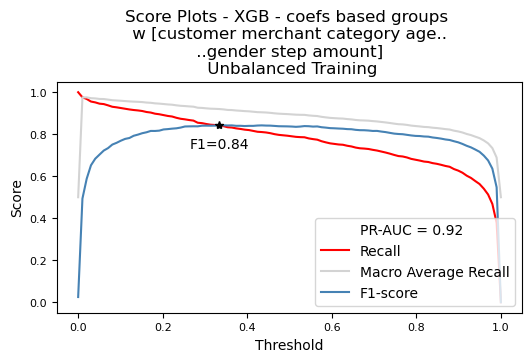

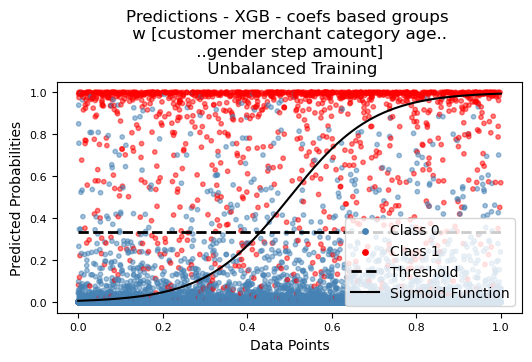

######### XGB - coefs based groups - w [customer merchant category age.. - ..gender step amount] - Unbalanced Training #########
Confusion Matrix - Optimal Threshold = 0.333

     0    1
117208  234
   235 1252

Classification Report - Optimal Threshold = 0.333

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117442
           1       0.84      0.84      0.84      1487

    accuracy                           1.00    118929
   macro avg       0.92      0.92      0.92    118929
weighted avg       1.00      1.00      1.00    118929



In [104]:
title = f'- XGB - coefs based groups \n w [customer merchant category age.. \n ..gender step amount] \n Unbalanced Training'
full_class_report(y_test, ypred_xgb, title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  sample0=1,
                  criterion='f1_recall_diff',
                  legend_loc='lower right', save_plot=False)

In [ ]:
_, pr_auc_xgb_coef, recall_xgb_coef, f1_xgb_coef, recall_macro_xgb_coef = (
    classification_plots(y_test, ypred_xgb, l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [106]:
print(f'pr_auc_xgb_coef: {pr_auc_xgb_coef},\nrecall_xgb_coef: {recall_xgb_coef},\nf1_xgb_coef: {f1_xgb_coef},\nrecall_macro_xgb_coef: {recall_macro_xgb_coef},')

pr_auc_xgb_coef: 0.9174383885669811,
recall_xgb_coef: 0.8419636852723604,
f1_xgb_coef: 0.8422468886646484,
recall_macro_xgb_coef: 0.9199856061960652,


In [107]:
beset_recall_xgb_coef = best_recall_thresh(y_test, ypred_xgb, 'xgb_coef', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_xgb_coef)

In [108]:
scr_xgb_coef = {
    'pr_auc_xgb_coef': pr_auc_xgb_coef,
    'recall_xgb_coef': recall_xgb_coef,
    'f1_xgb_coef': f1_xgb_coef,
    'recall_macro_xgb_coef': recall_macro_xgb_coef
}
scores_plot.update(scr_xgb_coef)

# Imbalanced Training - Adding all important features

# (7) New Features Added to Previous Model, Age, Gender, Step Removed

## Ridge - all new features

In [31]:
data_new_reduced = data_new.copy()
data_temp = data_new_reduced[['quant_cust_coef', 'quant_merch_coef', 'quant_cat_coef', 'amount', 'ratio_fraud', 'merch_spend', 'cat_spend', 'total_trans', 'fraud']].sample(frac=1, random_state=0)

# [['merchant', 'category', 'age', 'gender', 'step', 'amount', 'fraud']]

data3, X, y = one_hot_encode_pandas(data_temp, response='fraud', except_col=['fraud'], drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Original Labels
['quant_cust_coef', 'quant_merch_coef', 'quant_cat_coef', 'amount', 'ratio_fraud', 'merch_spend', 'cat_spend', 'total_trans']

Group Numbers (Groups used for plotting purposes not for regularization)
[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 5, 6, 7, 8]

1/30 lambda: 1.00e+06 - f1 = 0.00%
2/30 lambda: 6.21e+05 - f1 = 0.00%
3/30 lambda: 3.86e+05 - f1 = 0.18%
4/30 lambda: 2.40e+05 - f1 = 1.26%
5/30 lambda: 1.49e+05 - f1 = 5.31%
6/30 lambda: 9.24e+04 - f1 = 11.63%
7/30 lambda: 5.74e+04 - f1 = 27.70%
8/30 lambda: 3.56e+04 - f1 = 40.59%
9/30 lambda: 2.21e+04 - f1 = 49.97%
10/30 lambda: 1.37e+04 - f1 = 56.19%
11/30 lambda: 8.53e+03 - f1 = 63.01%
12/30 lambda: 5.30e+03 - f1 = 66.85%
13/30 lambda: 3.29e+03 - f1 = 71.74%
14/30 lambda: 2.04e+03 - f1 = 75.22%
15/30 lambda: 1.27e+03 - f1 = 77.71%
16/30 lambda: 7.88e+02 - f1 = 79.02%
17/30 lambda: 4.89e+02 - f1 = 80.78%
18/30 lambda: 3.04e+02 - f1 = 81.71%
19/30 lambda: 1.89e+02 - f1 = 82.16%
20/30 lambda: 1.17e+02 - f1 = 82.

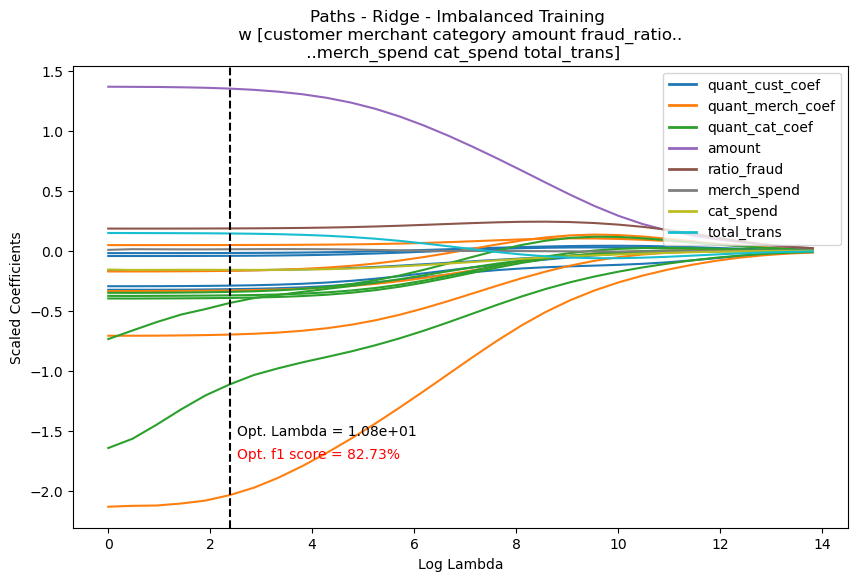

In [48]:
title = f'- Ridge - Imbalanced Training \n w [customer merchant category amount fraud_ratio.. \n ..merch_spend cat_spend total_trans]'
original_labels = data_temp.drop(columns=['fraud']).columns.tolist()
model_r, coefs_r, lam_r, ypred_r, group_lass_labels, labels, scores_r = (
    ridge_paths(X_train, y_train, X_test, original_labels,
                c_start=-6, c_stop=0, c_num=30,
                scoring='f1',
                n_iter=100,
                tol=1e-3,
                cmap='tab10',
                title=title,
                verbose=True,
                save_plot=False))

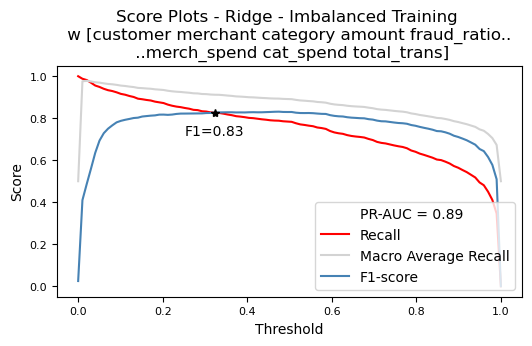

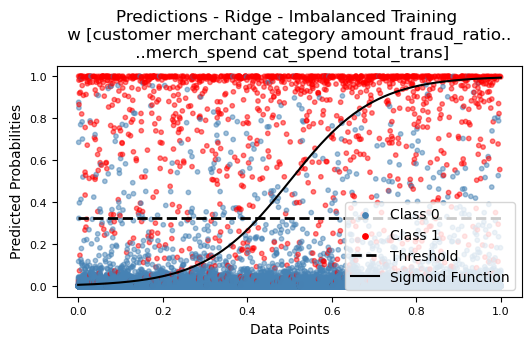

######### Ridge - Imbalanced Training - w [customer merchant category amount fraud_ratio.. - ..merch_spend cat_spend total_trans] #########
Confusion Matrix - Optimal Threshold = 0.323

     0    1
117187  255
   259 1228

Classification Report - Optimal Threshold = 0.323

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117442
           1       0.83      0.83      0.83      1487

    accuracy                           1.00    118929
   macro avg       0.91      0.91      0.91    118929
weighted avg       1.00      1.00      1.00    118929



In [49]:
full_class_report(y_test, ypred_r, title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  criterion='f1_recall_diff',
                  sample0=1,
                  legend_loc='lower right', save_plot=False)

In [ ]:
_, pr_auc_r_reduced, recall_r_reduced, f1_r_reduced, recall_macro_r_reduced = (
    classification_plots(y_test, ypred_r, l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [113]:
beset_recall_r_reduced = best_recall_thresh(y_test, ypred_r, 'r_reduced', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_r_reduced)

In [114]:
print(f'pr_auc_r_reduced: {pr_auc_r_reduced},\nrecall_r_reduced: {recall_r_reduced},\nf1_r_reduced: {f1_r_reduced},\nrecall_macro_r_reduced: {recall_macro_r_reduced},')

pr_auc_r_reduced: 0.8949754656119147,
recall_r_reduced: 0.8258238063214526,
f1_r_reduced: 0.8269360269360269,
recall_macro_r_reduced: 0.9118262608862419,


In [115]:
scr_r_reduced = {
    'pr_auc_r_reduced': pr_auc_r_reduced,
    'recall_r_reduced': recall_r_reduced,
    'f1_r_reduced': f1_r_reduced,
    'recall_macro_r_reduced': recall_macro_r_reduced
}
scores_plot.update(scr_r_reduced)

## SVM - all new features

In [32]:
C = [1]
bias = range(1)

svm_values = svm_model(X_train, y_train, X_test, y_test,
                        C, kernel='poly',
                        degree=3,
                        bias=bias,
                        scoring='f1',
                        verbose=True)

1. C = 1
    bias: 0
[LibSVM]Optimal Values: f1 score:  0.8523,  C: 1,   Bias: 0


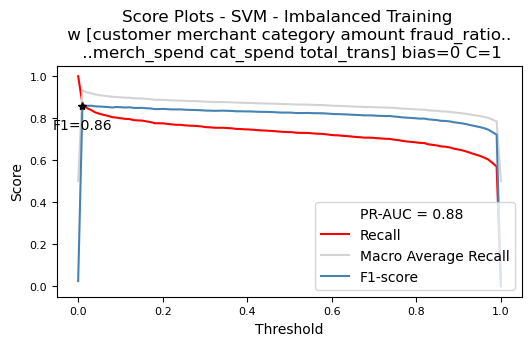

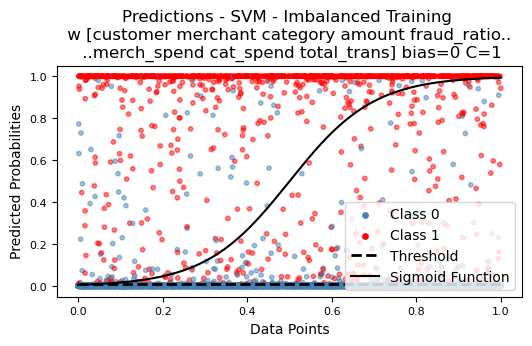

######### SVM - Imbalanced Training - w [customer merchant category amount fraud_ratio.. - ..merch_spend cat_spend total_trans] bias=0 C=1 #########
Confusion Matrix - Optimal Threshold = 0.010

     0    1
117213  229
   195 1292

Classification Report - Optimal Threshold = 0.010

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117442
           1       0.85      0.87      0.86      1487

    accuracy                           1.00    118929
   macro avg       0.92      0.93      0.93    118929
weighted avg       1.00      1.00      1.00    118929



In [36]:
title=f"- SVM - Imbalanced Training \n w [customer merchant category amount fraud_ratio.. \n ..merch_spend cat_spend total_trans] bias={svm_values['bias_opt']} C={svm_values['C_opt']}"
full_class_report(y_test, svm_values['y_svm'], title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  criterion='f1_recall_diff',
                  sample0=1,
                  legend_loc='lower right', save_plot=False)

In [ ]:
_, pr_auc_svm_reduced, recall_svm_reduced, f1_svm_reduced, recall_macro_svm_reduced = (
    classification_plots(y_test, svm_values['y_svm'], l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [119]:
print(f'pr_auc_svm_reduced: {pr_auc_svm_reduced}\nrecall_svm_reduced: {recall_svm_reduced}\nf1_svm_reduced: {f1_svm_reduced}\nrecall_macro_svm_reduced: {recall_macro_svm_reduced}')

pr_auc_svm_reduced: 0.8803878721301271
recall_svm_reduced: 0.8493611297915266
f1_svm_reduced: 0.8594760122490643
recall_macro_svm_reduced: 0.9238759123864395


In [120]:
beset_recall_svm_reduced = best_recall_thresh(y_test, svm_values['y_svm'], 'svm_reduced', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_svm_reduced)

In [121]:
scr_svm_reduced = {
    'pr_auc_svm_reduced': pr_auc_svm_reduced,
    'recall_svm_reduced': recall_svm_reduced,
    'f1_svm_reduced': f1_svm_reduced,
    'recall_macro_svm_reduced': recall_macro_svm_reduced
}
scores_plot.update(scr_svm_reduced)

## XGB - all new features

In [50]:
xgb_model2, ypred_xgb = xgb_logistic_model(X_train, y_train, X_test, y_test, eval_metric='aucpr', max_depth=3, threads=4, iter=27, verbose=True)

[0]	train-aucpr:0.75755	eval-aucpr:0.76935
[1]	train-aucpr:0.85862	eval-aucpr:0.86360
[2]	train-aucpr:0.87654	eval-aucpr:0.87993
[3]	train-aucpr:0.89649	eval-aucpr:0.89682
[4]	train-aucpr:0.90835	eval-aucpr:0.90779
[5]	train-aucpr:0.91338	eval-aucpr:0.91225
[6]	train-aucpr:0.92038	eval-aucpr:0.91884
[7]	train-aucpr:0.92407	eval-aucpr:0.92328
[8]	train-aucpr:0.92855	eval-aucpr:0.92672
[9]	train-aucpr:0.93297	eval-aucpr:0.92783
[10]	train-aucpr:0.93811	eval-aucpr:0.93296
[11]	train-aucpr:0.94132	eval-aucpr:0.93644
[12]	train-aucpr:0.94411	eval-aucpr:0.93885
[13]	train-aucpr:0.94474	eval-aucpr:0.93847
[14]	train-aucpr:0.94719	eval-aucpr:0.93916
[15]	train-aucpr:0.94838	eval-aucpr:0.94129
[16]	train-aucpr:0.94929	eval-aucpr:0.94119
[17]	train-aucpr:0.94999	eval-aucpr:0.94106
[18]	train-aucpr:0.95040	eval-aucpr:0.94085
[19]	train-aucpr:0.95134	eval-aucpr:0.94213
[20]	train-aucpr:0.95240	eval-aucpr:0.94149
[21]	train-aucpr:0.95301	eval-aucpr:0.94203
[22]	train-aucpr:0.95362	eval-aucpr:0.9421

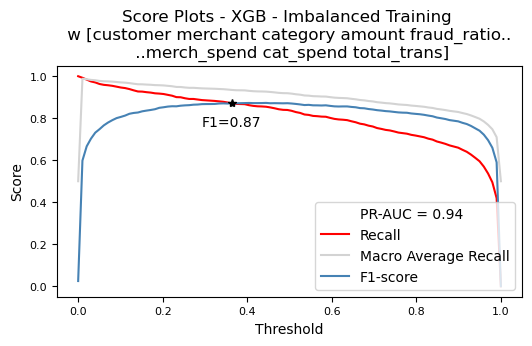

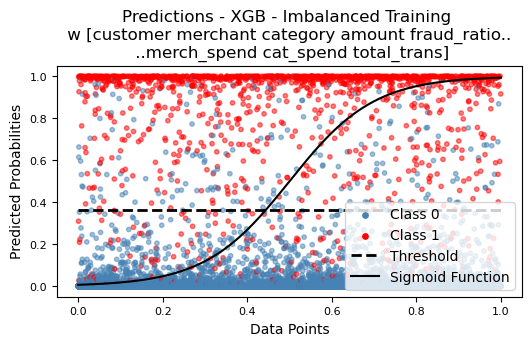

######### XGB - Imbalanced Training - w [customer merchant category amount fraud_ratio.. - ..merch_spend cat_spend total_trans] #########
Confusion Matrix - Optimal Threshold = 0.364

     0    1
117251  191
   192 1295

Classification Report - Optimal Threshold = 0.364

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117442
           1       0.87      0.87      0.87      1487

    accuracy                           1.00    118929
   macro avg       0.93      0.93      0.93    118929
weighted avg       1.00      1.00      1.00    118929



In [51]:
title = f'- XGB - Imbalanced Training \n w [customer merchant category amount fraud_ratio.. \n ..merch_spend cat_spend total_trans]'
full_class_report(y_test, ypred_xgb, title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  sample0=1,
                  criterion='f1_recall_diff',
                  legend_loc='lower right', save_plot=False)

In [ ]:
_, pr_auc_xgb_reduced, recall_xgb_reduced, f1_xgb_reduced, recall_macro_xgb_reduced = (
    classification_plots(y_test, ypred_xgb, l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [125]:
print(f'pr_auc_xgb_reduced: {pr_auc_xgb_reduced},\nrecall_xgb_reduced: {recall_xgb_reduced},\nf1_xgb_reduced: {f1_xgb_reduced},\nrecall_macro_xgb_reduced: {recall_macro_xgb_reduced},')

pr_auc_xgb_reduced: 0.9429066433932312,
recall_xgb_reduced: 0.8708809683927371,
f1_xgb_reduced: 0.8711738984191052,
recall_macro_xgb_reduced: 0.9346273168456762,


In [126]:
beset_recall_xgb_reduced = best_recall_thresh(y_test, ypred_xgb, 'xgb_reduced', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_xgb_reduced)

In [127]:
scr_xgb_reduced = {
    'pr_auc_xgb_reduced': pr_auc_xgb_reduced,
    'recall_xgb_reduced': recall_xgb_reduced,
    'f1_xgb_reduced': f1_xgb_reduced,
    'recall_macro_xgb_reduced': recall_macro_xgb_reduced
}
scores_plot.update(scr_xgb_reduced)

# (8) New Features Added to Previous Model, Age, Gender, Step Removed (Training set reduced to 0.1)

## Ridge - all new features (Training set reduced to 0.1)

In [128]:
data_new_reduced = data_new.copy()
data_temp = data_new_reduced[
    ['quant_cust_coef', 'quant_merch_coef', 'quant_cat_coef', 'amount', 'ratio_fraud', 'merch_spend', 'cat_spend',
     'total_trans', 'fraud']].sample(frac=1, random_state=0)

# [['merchant', 'category', 'age', 'gender', 'step', 'amount', 'fraud']]

data3, X, y = one_hot_encode_pandas(data_temp, response='fraud', except_col=['fraud'], drop_first=True)
X_trains, X_test, y_trains, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [129]:
X_train = X_trains.reset_index(drop=True).sample(frac=0.1, random_state=0)
y_train = y_trains.reset_index(drop=True).sample(frac=0.1, random_state=0)

Original Labels
['quant_cust_coef', 'quant_merch_coef', 'quant_cat_coef', 'amount', 'ratio_fraud', 'merch_spend', 'cat_spend', 'total_trans']

Group Numbers (Groups used for plotting purposes not for regularization)
[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 5, 6, 7, 8]

1/30 lambda: 1.00e+06 - f1 = 0.00%
2/30 lambda: 6.21e+05 - f1 = 0.00%
3/30 lambda: 3.86e+05 - f1 = 0.00%
4/30 lambda: 2.40e+05 - f1 = 0.00%
5/30 lambda: 1.49e+05 - f1 = 0.00%
6/30 lambda: 9.24e+04 - f1 = 0.00%
7/30 lambda: 5.74e+04 - f1 = 0.00%
8/30 lambda: 3.56e+04 - f1 = 0.00%
9/30 lambda: 2.21e+04 - f1 = 1.67%
10/30 lambda: 1.37e+04 - f1 = 8.06%
11/30 lambda: 8.53e+03 - f1 = 16.92%
12/30 lambda: 5.30e+03 - f1 = 29.58%
13/30 lambda: 3.29e+03 - f1 = 41.03%
14/30 lambda: 2.04e+03 - f1 = 48.78%
15/30 lambda: 1.27e+03 - f1 = 57.14%
16/30 lambda: 7.88e+02 - f1 = 63.78%
17/30 lambda: 4.89e+02 - f1 = 66.67%
18/30 lambda: 3.04e+02 - f1 = 71.43%
19/30 lambda: 1.89e+02 - f1 = 74.88%
20/30 lambda: 1.17e+02 - f1 = 78.85%
2

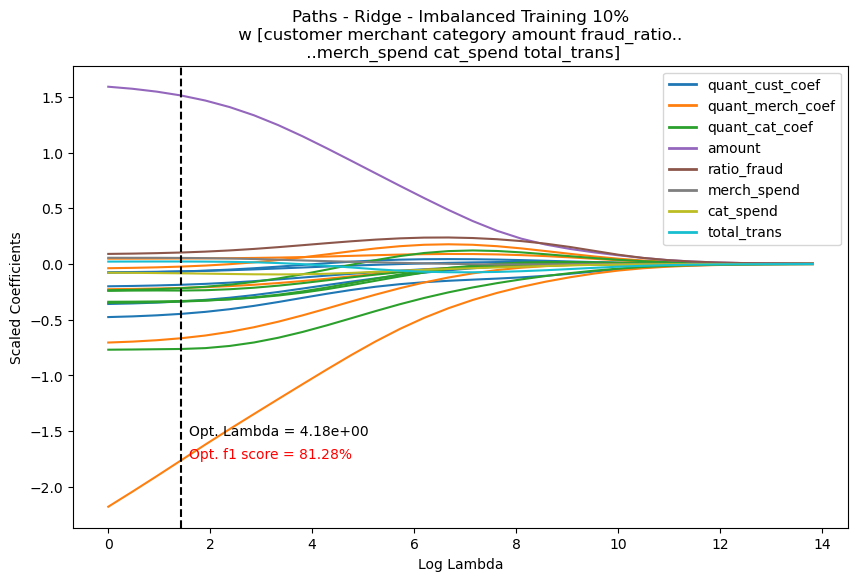

In [130]:
title = f'- Ridge - Imbalanced Training 10%\n w [customer merchant category amount fraud_ratio.. \n ..merch_spend cat_spend total_trans]'
original_labels = data_temp.drop(columns=['fraud']).columns.tolist()
model_r, coefs_r, lam_r, ypred_r, group_lass_labels, labels, scores_r = (
    ridge_paths(X_train, y_train, X_test, original_labels,
                c_start=-6, c_stop=0, c_num=30,
                scoring='f1',
                n_iter=100,
                tol=1e-3,
                cmap='tab10',
                title=title,
                verbose=True,
                save_plot=False))

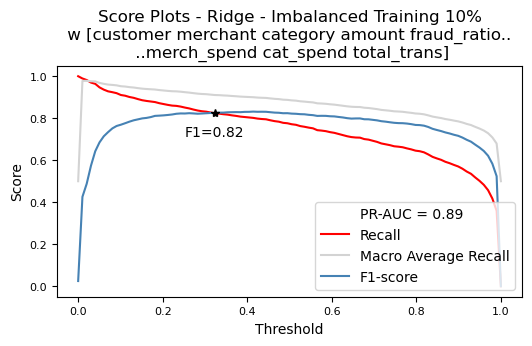

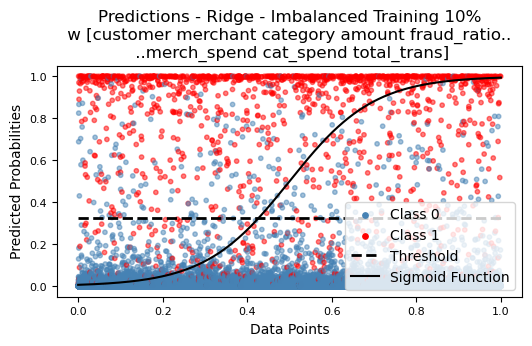

######### Ridge - Imbalanced Training 10%- w [customer merchant category amount fraud_ratio.. - ..merch_spend cat_spend total_trans] #########
Confusion Matrix - Optimal Threshold = 0.323

     0    1
117183  259
   263 1224

Classification Report - Optimal Threshold = 0.323

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117442
           1       0.83      0.82      0.82      1487

    accuracy                           1.00    118929
   macro avg       0.91      0.91      0.91    118929
weighted avg       1.00      1.00      1.00    118929



In [131]:
full_class_report(y_test, ypred_r, title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  criterion='f1_recall_diff',
                  sample0=1,
                  legend_loc='lower right', save_plot=False)

In [ ]:
_, pr_auc_r_reduced_frac, recall_r_reduced_frac, f1_r_reduced_frac, recall_macro_r_reduced_frac = (
    classification_plots(y_test, ypred_r, l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [133]:
print(f'pr_auc_r_reduced_frac: {pr_auc_r_reduced_frac},\nrecall_r_reduced_frac: {recall_r_reduced_frac},\nf1_r_reduced_frac: {f1_r_reduced_frac},\nrecall_macro_r_reduced_frac: {recall_macro_r_reduced_frac},')

pr_auc_r_reduced_frac: 0.8912892326347227,
recall_r_reduced_frac: 0.8231338264963013,
f1_r_reduced_frac: 0.8242424242424242,
recall_macro_r_reduced_frac: 0.9104642412909292,


In [134]:
beset_recall_r_reduced_frac = best_recall_thresh(y_test, ypred_r, 'r_reduced_frac', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_r_reduced_frac)

In [135]:
scr_r_reduced_frac = {
    'pr_auc_r_reduced_frac': pr_auc_r_reduced_frac,
    'recall_r_reduced_frac': recall_r_reduced_frac,
    'f1_r_reduced_frac': f1_r_reduced_frac,
    'recall_macro_r_reduced_frac': recall_macro_r_reduced_frac
}
scores_plot.update(scr_r_reduced_frac)

## SVM - all new features (Training set reduced to 0.1)

In [136]:
C = [1]
bias = range(1)

svm_values = svm_model(X_train, y_train, X_test, y_test,
                        C, kernel='poly',
                        degree=3,
                        bias=bias,
                        scoring='recall_macro',
                        verbose=True)

1. C = 1
    bias: 0
[LibSVM]Optimal Values: recall_macro score:  0.8902,  C: 1,   Bias: 0


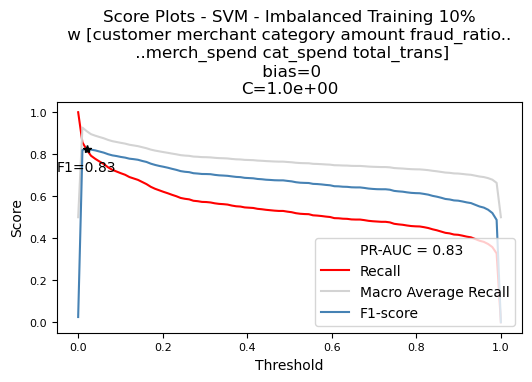

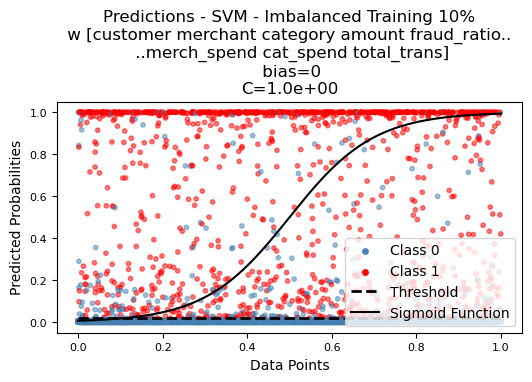

######### SVM - Imbalanced Training 10%- w [customer merchant category amount fraud_ratio.. - ..merch_spend cat_spend total_trans]- bias=0-C=1.0e+00 #########
Confusion Matrix - Optimal Threshold = 0.020

     0    1
117193  249
   265 1222

Classification Report - Optimal Threshold = 0.020

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117442
           1       0.83      0.82      0.83      1487

    accuracy                           1.00    118929
   macro avg       0.91      0.91      0.91    118929
weighted avg       1.00      1.00      1.00    118929



In [137]:
title=f"- SVM - Imbalanced Training 10%\n w [customer merchant category amount fraud_ratio.. \n ..merch_spend cat_spend total_trans]\n bias={svm_values['bias_opt']}\nC={svm_values['C_opt']:.1e}"
full_class_report(y_test, svm_values['y_svm'], title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  criterion='f1_recall_diff',
                  sample0=1,
                  legend_loc='lower right', save_plot=False)

In [ ]:
_, pr_auc_svm_reduced_frac, recall_svm_reduced_frac, f1_svm_reduced_frac, recall_macro_svm_reduced_frac = (
    classification_plots(y_test, svm_values['y_svm'], l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [139]:
print(f'pr_auc_svm_reduced_frac: {pr_auc_svm_reduced_frac}\nrecall_svm_reduced_frac: {recall_svm_reduced_frac}\nf1_svm_reduced_frac: {f1_svm_reduced_frac}\nrecall_macro_svm_reduced_frac: {recall_macro_svm_reduced_frac}')

pr_auc_svm_reduced_frac: 0.8253197255986714
recall_svm_reduced_frac: 0.8217888365837256
f1_svm_reduced_frac: 0.8262339418526032
recall_macro_svm_reduced_frac: 0.9098343205414838


In [140]:
beset_recall_svm_reduced_frac = best_recall_thresh(y_test, svm_values['y_svm'], 'svm_reduced_frac', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_svm_reduced_frac)

In [141]:
scr_svm_reduced_frac = {
    'pr_auc_svm_reduced_frac': pr_auc_svm_reduced_frac,
    'recall_svm_reduced_frac': recall_svm_reduced_frac,
    'f1_svm_reduced_frac': f1_svm_reduced_frac,
    'recall_macro_svm_reduced_frac': recall_macro_svm_reduced_frac
}
scores_plot.update(scr_svm_reduced_frac)

## XGB - all new features (Training set reduced to 0.1)

In [142]:
xgb_model2, ypred_xgb = xgb_logistic_model(X_train, y_train, X_test, y_test, eval_metric='aucpr', max_depth=3, threads=4, iter=17, verbose=True)

[0]	train-aucpr:0.75250	eval-aucpr:0.74921
[1]	train-aucpr:0.87575	eval-aucpr:0.86199
[2]	train-aucpr:0.89659	eval-aucpr:0.87394
[3]	train-aucpr:0.91245	eval-aucpr:0.89425
[4]	train-aucpr:0.92534	eval-aucpr:0.90599
[5]	train-aucpr:0.93226	eval-aucpr:0.91224
[6]	train-aucpr:0.93534	eval-aucpr:0.91191
[7]	train-aucpr:0.94065	eval-aucpr:0.91074
[8]	train-aucpr:0.94422	eval-aucpr:0.91037
[9]	train-aucpr:0.94891	eval-aucpr:0.91090
[10]	train-aucpr:0.95377	eval-aucpr:0.91298
[11]	train-aucpr:0.95574	eval-aucpr:0.91441
[12]	train-aucpr:0.95953	eval-aucpr:0.91689
[13]	train-aucpr:0.96392	eval-aucpr:0.91796
[14]	train-aucpr:0.96607	eval-aucpr:0.92188
[15]	train-aucpr:0.96824	eval-aucpr:0.92063
[16]	train-aucpr:0.96996	eval-aucpr:0.92208


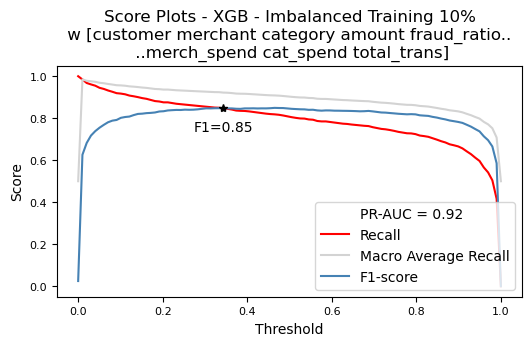

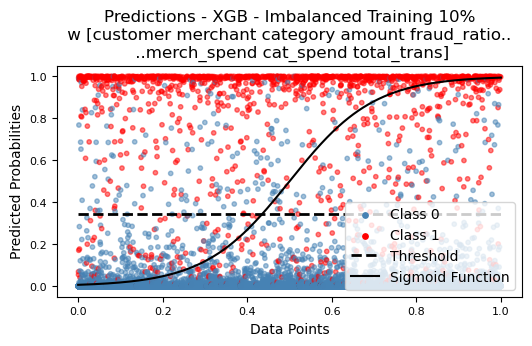

######### XGB - Imbalanced Training 10%- w [customer merchant category amount fraud_ratio.. - ..merch_spend cat_spend total_trans] #########
Confusion Matrix - Optimal Threshold = 0.343

     0    1
117216  226
   229 1258

Classification Report - Optimal Threshold = 0.343

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117442
           1       0.85      0.85      0.85      1487

    accuracy                           1.00    118929
   macro avg       0.92      0.92      0.92    118929
weighted avg       1.00      1.00      1.00    118929



In [143]:
title = f'- XGB - Imbalanced Training 10%\n w [customer merchant category amount fraud_ratio.. \n ..merch_spend cat_spend total_trans]'
full_class_report(y_test, ypred_xgb, title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  sample0=1,
                  criterion='f1_recall_diff',
                  legend_loc='lower right', save_plot=False)

In [ ]:
_, pr_auc_xgb_reduced_frac, recall_xgb_reduced_frac, f1_xgb_reduced_frac, recall_macro_xgb_reduced_frac = (
    classification_plots(y_test, ypred_xgb, l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [145]:
print(f'pr_auc_xgb_reduced_frac: {pr_auc_xgb_reduced_frac},\nrecall_xgb_reduced_frac: {recall_xgb_reduced_frac},\nf1_xgb_reduced_frac: {f1_xgb_reduced_frac},\nrecall_macro_xgb_reduced_frac: {recall_macro_xgb_reduced_frac},')

pr_auc_xgb_reduced_frac: 0.9220960799370144,
recall_xgb_reduced_frac: 0.8459986550100874,
f1_xgb_reduced_frac: 0.8468529114776171,
recall_macro_xgb_reduced_frac: 0.9220371504304026,


In [146]:
beset_recall_xgb_reduced_frac = best_recall_thresh(y_test, ypred_xgb, 'xgb_reduced_frac', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_xgb_reduced_frac)

In [147]:
scr_xgb_reduced_frac = {
    'pr_auc_xgb_reduced_frac': pr_auc_xgb_reduced_frac,
    'recall_xgb_reduced_frac': recall_xgb_reduced_frac,
    'f1_xgb_reduced_frac': f1_xgb_reduced_frac,
    'recall_macro_xgb_reduced_frac': recall_macro_xgb_reduced_frac
}
scores_plot.update(scr_xgb_reduced_frac)

# (9) Class 0 Pulled Back
I split the data similarly to other models, but then I undersampled class 0 in the training set. 'lam' is a multiplier between 0 and 0.79099 to control the amount of undersampling. lam=0 balances the two classes, i.e. class 1 to class 0 ratio ~ 100%, lam=0.79099 makes the ratio of class 1 to class 0 1.53405%.

The orginial set has the ratio at 1.21553%


## Ridge - Class 0 Pulled Back

In [148]:
data_new_reduced = data_new.copy()
data_temp = data_new_reduced[
    ['quant_cust_coef', 'quant_merch_coef', 'quant_cat_coef', 'amount', 'ratio_fraud', 'merch_spend', 'cat_spend',
     'total_trans', 'fraud']].sample(frac=1, random_state=0)

# [['merchant', 'category', 'age', 'gender', 'step', 'amount', 'fraud']]

data3, X, y = one_hot_encode_pandas(data_temp, response='fraud', except_col=['fraud'], drop_first=True)
X_trains, X_test, y_trains, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [149]:
# pulling back class 0 from training set slightly while keeping the testing set the same as all other models. Ignore verbose about Test Count
X_train, y_train, _, _ = sub_split_flex(X_trains.reset_index(drop=True), y_trains.reset_index(drop=True), lam=0.6, verbose=True)

Train Count
fraud
0    227359
1      4639
Name: fraud, dtype: int64 

Test Count
fraud
0    89430
1     1074
Name: fraud, dtype: int64

Original class 1 to class 0 ratio for the training set: 1.21553%
New class 1 to class 0 ratio for the training set: 2.04039%


Original Labels
['quant_cust_coef', 'quant_merch_coef', 'quant_cat_coef', 'amount', 'ratio_fraud', 'merch_spend', 'cat_spend', 'total_trans']

Group Numbers (Groups used for plotting purposes not for regularization)
[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 5, 6, 7, 8]

1/30 lambda: 1.00e+06 - f1 = 0.00%
2/30 lambda: 6.21e+05 - f1 = 0.00%
3/30 lambda: 3.86e+05 - f1 = 0.00%
4/30 lambda: 2.40e+05 - f1 = 0.00%
5/30 lambda: 1.49e+05 - f1 = 1.07%
6/30 lambda: 9.24e+04 - f1 = 6.85%
7/30 lambda: 5.74e+04 - f1 = 17.83%
8/30 lambda: 3.56e+04 - f1 = 36.22%
9/30 lambda: 2.21e+04 - f1 = 50.28%
10/30 lambda: 1.37e+04 - f1 = 57.87%
11/30 lambda: 8.53e+03 - f1 = 64.03%
12/30 lambda: 5.30e+03 - f1 = 68.75%
13/30 lambda: 3.29e+03 - f1 = 73.49%
14/30 lambda: 2.04e+03 - f1 = 77.09%
15/30 lambda: 1.27e+03 - f1 = 80.69%
16/30 lambda: 7.88e+02 - f1 = 82.23%
17/30 lambda: 4.89e+02 - f1 = 84.04%
18/30 lambda: 3.04e+02 - f1 = 84.58%
19/30 lambda: 1.89e+02 - f1 = 85.81%
20/30 lambda: 1.17e+02 - f1 = 86.3

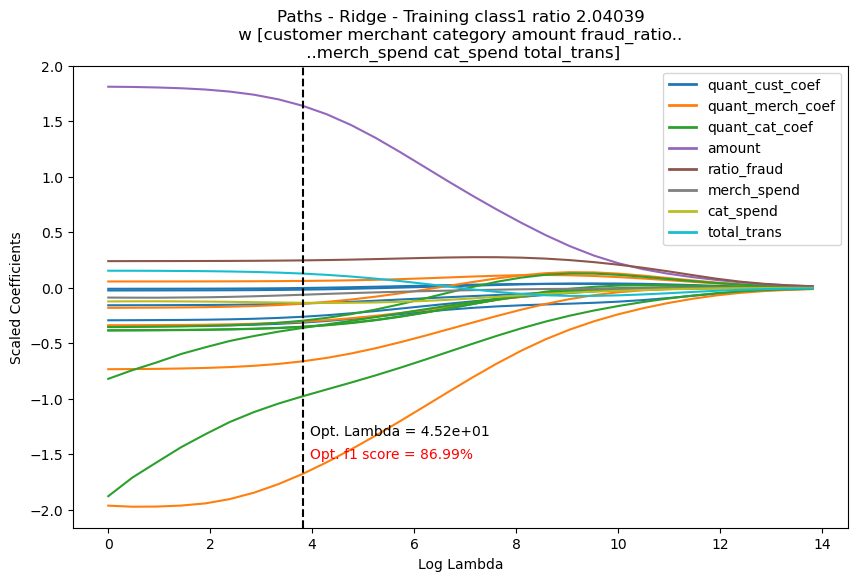

In [150]:
title = f'- Ridge - Training class1 ratio 2.04039\n w [customer merchant category amount fraud_ratio.. \n ..merch_spend cat_spend total_trans]'
original_labels = data_temp.drop(columns=['fraud']).columns.tolist()
model_r, coefs_r, lam_r, ypred_r, group_lass_labels, labels, scores_r = (
    ridge_paths(X_train, y_train, X_test, original_labels,
                c_start=-6, c_stop=0, c_num=30,
                scoring='f1',
                n_iter=100,
                tol=1e-3,
                cmap='tab10',
                title=title,
                verbose=True,
                save_plot=False))

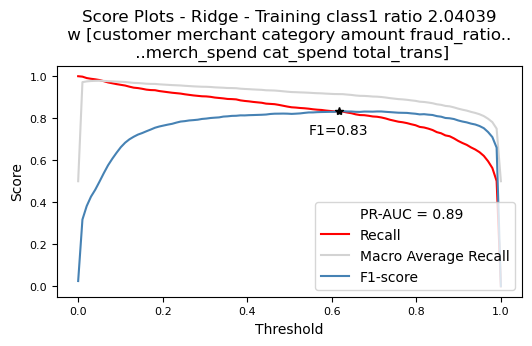

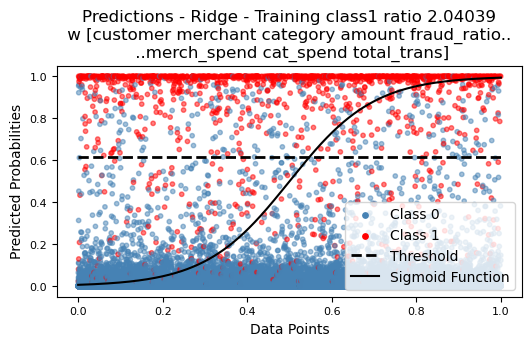

######### Ridge - Training class1 ratio 2.04039- w [customer merchant category amount fraud_ratio.. - ..merch_spend cat_spend total_trans] #########
Confusion Matrix - Optimal Threshold = 0.616

     0    1
117195  247
   250 1237

Classification Report - Optimal Threshold = 0.616

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117442
           1       0.83      0.83      0.83      1487

    accuracy                           1.00    118929
   macro avg       0.92      0.91      0.92    118929
weighted avg       1.00      1.00      1.00    118929



In [151]:
full_class_report(y_test, ypred_r, title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  criterion='f1_recall_diff',
                  sample0=1,
                  legend_loc='lower right', save_plot=False)

In [ ]:
_, pr_auc_r_reduced_pb, recall_r_reduced_pb, f1_r_reduced_pb, recall_macro_r_reduced_pb = (
    classification_plots(y_test, ypred_r, l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [153]:
print(f'pr_auc_r_reduced_pb: {pr_auc_r_reduced_pb},\nrecall_r_reduced_pb: {recall_r_reduced_pb},\nf1_r_reduced_pb: {f1_r_reduced_pb},\nrecall_macro_r_reduced_pb: {recall_macro_r_reduced_pb},')

pr_auc_r_reduced_pb: 0.8939150062941754,
recall_r_reduced_pb: 0.831876260928043,
f1_r_reduced_pb: 0.8327162571524739,
recall_macro_r_reduced_pb: 0.9148865475550111,


In [154]:
beset_recall_r_reduced_pb = best_recall_thresh(y_test, ypred_r, 'r_reduced_pb', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_r_reduced_pb)

In [155]:
scr_r_reduced_pb = {
    'pr_auc_r_reduced_pb': pr_auc_r_reduced_pb,
    'recall_r_reduced_pb': recall_r_reduced_pb,
    'f1_r_reduced_pb': f1_r_reduced_pb,
    'recall_macro_r_reduced_pb': recall_macro_r_reduced_pb
}
scores_plot.update(scr_r_reduced_pb)

In [156]:
y_thresh = [1 if i > 0.05 else 0 for i in ypred_r]
confusion_matrix(y_test, y_thresh)

array([[114506,   2936],
       [    27,   1460]], dtype=int64)

## SVM - Class 0 Pulled Back

In [157]:
C = [1]
bias = range(1)

svm_values = svm_model(X_train, y_train, X_test, y_test,
                        C, kernel='poly',
                        degree=3,
                        bias=bias,
                        scoring='recall_macro',
                        verbose=True)

1. C = 1
    bias: 0
[LibSVM]Optimal Values: recall_macro score:  0.9400,  C: 1,   Bias: 0


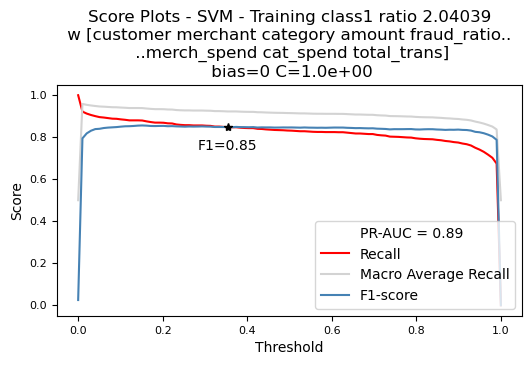

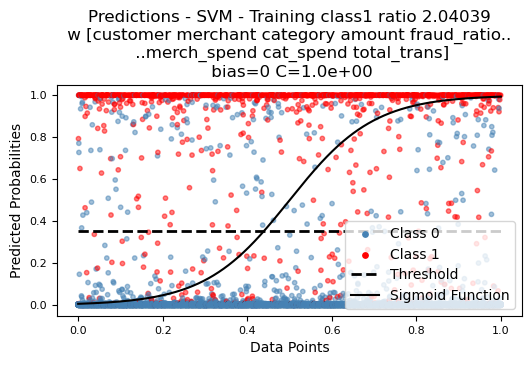

######### SVM - Training class1 ratio 2.04039- w [customer merchant category amount fraud_ratio.. - ..merch_spend cat_spend total_trans]- bias=0 C=1.0e+00 #########
Confusion Matrix - Optimal Threshold = 0.354

     0    1
117217  225
   227 1260

Classification Report - Optimal Threshold = 0.354

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117442
           1       0.85      0.85      0.85      1487

    accuracy                           1.00    118929
   macro avg       0.92      0.92      0.92    118929
weighted avg       1.00      1.00      1.00    118929



In [158]:
title=f"- SVM - Training class1 ratio 2.04039\n w [customer merchant category amount fraud_ratio.. \n ..merch_spend cat_spend total_trans]\n bias={svm_values['bias_opt']} C={svm_values['C_opt']:.1e}"
full_class_report(y_test, svm_values['y_svm'], title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  criterion='f1_recall_diff',
                  sample0=1,
                  legend_loc='lower right', save_plot=False)

In [ ]:
_, pr_auc_svm_reduced_pb, recall_svm_reduced_pb, f1_svm_reduced_pb, recall_macro_svm_reduced_pb = (
    classification_plots(y_test, svm_values['y_svm'], l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [160]:
print(f'pr_auc_svm_reduced_pb: {pr_auc_svm_reduced_pb}\nrecall_svm_reduced_pb: {recall_svm_reduced_pb}\nf1_svm_reduced_pb: {f1_svm_reduced_pb}\nrecall_macro_svm_reduced_pb: {recall_macro_svm_reduced_pb}')

pr_auc_svm_reduced_pb: 0.8934751781010272
recall_svm_reduced_pb: 0.8473436449226631
f1_svm_reduced_pb: 0.847913862718708
recall_macro_svm_reduced_pb: 0.9227139028073748


In [161]:
beset_recall_svm_reduced_pb = best_recall_thresh(y_test, svm_values['y_svm'], 'svm_reduced_pb', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_svm_reduced_pb)

In [162]:
scr_svm_reduced_pb = {
    'pr_auc_svm_reduced_pb': pr_auc_svm_reduced_pb,
    'recall_svm_reduced_pb': recall_svm_reduced_pb,
    'f1_svm_reduced_pb': f1_svm_reduced_pb,
    'recall_macro_svm_reduced_pb': recall_macro_svm_reduced_pb
}
scores_plot.update(scr_svm_reduced_pb)

## XGB - Class 0 Pulled Back

In [163]:
xgb_model2, ypred_xgb = xgb_logistic_model(X_train, y_train, X_test, y_test, eval_metric='aucpr', max_depth=3, threads=4, iter=30, verbose=True)

[0]	train-aucpr:0.80228	eval-aucpr:0.77949
[1]	train-aucpr:0.90179	eval-aucpr:0.87052
[2]	train-aucpr:0.91687	eval-aucpr:0.88597
[3]	train-aucpr:0.92579	eval-aucpr:0.89628
[4]	train-aucpr:0.93848	eval-aucpr:0.91103
[5]	train-aucpr:0.94077	eval-aucpr:0.91296
[6]	train-aucpr:0.94454	eval-aucpr:0.92024
[7]	train-aucpr:0.94812	eval-aucpr:0.92248
[8]	train-aucpr:0.95311	eval-aucpr:0.92530
[9]	train-aucpr:0.95560	eval-aucpr:0.92791
[10]	train-aucpr:0.95798	eval-aucpr:0.93140
[11]	train-aucpr:0.96026	eval-aucpr:0.93435
[12]	train-aucpr:0.96184	eval-aucpr:0.93549
[13]	train-aucpr:0.96323	eval-aucpr:0.93673
[14]	train-aucpr:0.96489	eval-aucpr:0.93832
[15]	train-aucpr:0.96515	eval-aucpr:0.93761
[16]	train-aucpr:0.96600	eval-aucpr:0.93771
[17]	train-aucpr:0.96628	eval-aucpr:0.93772
[18]	train-aucpr:0.96794	eval-aucpr:0.94017
[19]	train-aucpr:0.96872	eval-aucpr:0.93907
[20]	train-aucpr:0.96929	eval-aucpr:0.93851
[21]	train-aucpr:0.96986	eval-aucpr:0.93870
[22]	train-aucpr:0.97016	eval-aucpr:0.9380

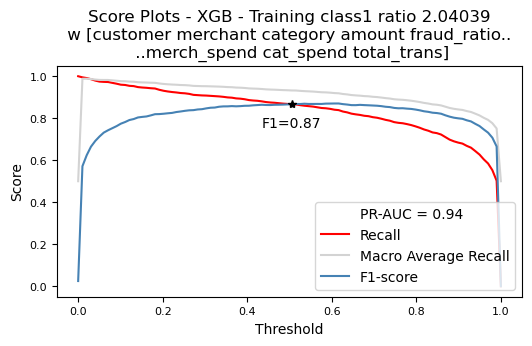

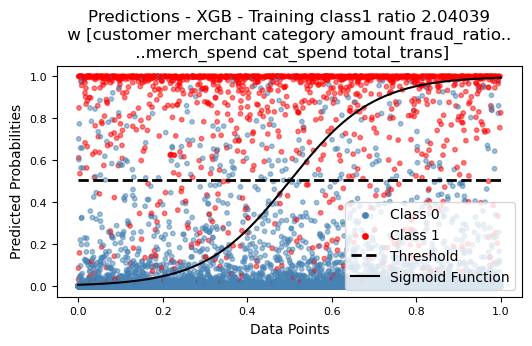

######### XGB - Training class1 ratio 2.04039- w [customer merchant category amount fraud_ratio.. - ..merch_spend cat_spend total_trans] #########
Confusion Matrix - Optimal Threshold = 0.505

     0    1
117244  198
   199 1288

Classification Report - Optimal Threshold = 0.505

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117442
           1       0.87      0.87      0.87      1487

    accuracy                           1.00    118929
   macro avg       0.93      0.93      0.93    118929
weighted avg       1.00      1.00      1.00    118929



In [164]:
title = f'- XGB - Training class1 ratio 2.04039\n w [customer merchant category amount fraud_ratio.. \n ..merch_spend cat_spend total_trans]'
full_class_report(y_test, ypred_xgb, title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  sample0=1,
                  criterion='f1_recall_diff',
                  legend_loc='lower right', save_plot=False)

In [ ]:
_, pr_auc_xgb_reduced_pb, recall_xgb_reduced_pb, f1_xgb_reduced_pb, recall_macro_xgb_reduced_pb = (
    classification_plots(y_test, ypred_xgb, l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [166]:
print(f'pr_auc_xgb_reduced_pb: {pr_auc_xgb_reduced_pb},\nrecall_xgb_reduced_pb: {recall_xgb_reduced_pb},\nf1_xgb_reduced_pb: {f1_xgb_reduced_pb},\nrecall_macro_xgb_reduced_pb: {recall_macro_xgb_reduced_pb},')

pr_auc_xgb_reduced_pb: 0.9406094694294754,
recall_xgb_reduced_pb: 0.8661735036987223,
f1_xgb_reduced_pb: 0.8664648503195426,
recall_macro_xgb_reduced_pb: 0.9322437825538792,


In [167]:
beset_recall_xgb_reduced_pb = best_recall_thresh(y_test, ypred_xgb, 'xgb_reduced_pb', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_xgb_reduced_pb)

In [168]:
scr_xgb_reduced_pb = {
    'pr_auc_xgb_reduced_pb': pr_auc_xgb_reduced_pb,
    'recall_xgb_reduced_pb': recall_xgb_reduced_pb,
    'f1_xgb_reduced_pb': f1_xgb_reduced_pb,
    'recall_macro_xgb_reduced_pb': recall_macro_xgb_reduced_pb
}
scores_plot.update(scr_xgb_reduced_pb)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

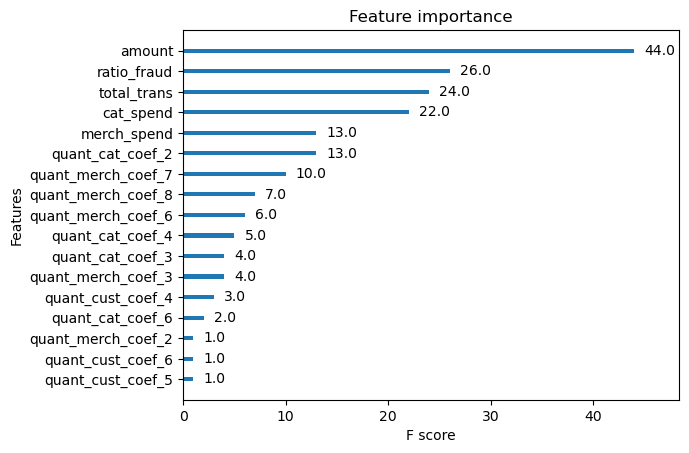

In [169]:
xgb.plot_importance(xgb_model2, grid=False)

In [170]:
y_thresh = [1 if i > 0.05 else 0 for i in ypred_xgb]
confusion_matrix(y_test, y_thresh)

array([[116306,   1136],
       [    38,   1449]], dtype=int64)

# (10) BALANCED TRAINING

# Ridge - Balanced Training


In [171]:
data_new_reduced = data_new.copy()
data_temp = data_new_reduced[['quant_cust_coef', 'quant_merch_coef', 'quant_cat_coef', 'amount', 'ratio_fraud', 'merch_spend', 'cat_spend', 'total_trans', 'fraud']].sample(frac=1, random_state=0)
data3, X, y = one_hot_encode_pandas(data_temp, response='fraud', except_col=['fraud'])

#[['customer', 'merchant', 'category', 'age', 'gender', 'step', 'amount', 'fraud']]

X_trains, X_test, y_trains, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [172]:
# pulling back class 0 from training set to balance it with class 1 while keeping the testing set the same as all other models. Ignore verbose about Test Count
X_train, y_train, _, _ = sub_split_flex(X_trains.reset_index(drop=True), y_trains.reset_index(drop=True), lam=0, verbose=True)

Train Count
fraud
0    4561
1    4579
Name: fraud, dtype: int64 

Test Count
fraud
0    94426
1     1134
Name: fraud, dtype: int64

Original class 1 to class 0 ratio for the training set: 1.21553%
New class 1 to class 0 ratio for the training set: 100.39465%


Original Labels
['quant_cust_coef', 'quant_merch_coef', 'quant_cat_coef', 'amount', 'ratio_fraud', 'merch_spend', 'cat_spend', 'total_trans']

Group Numbers (Groups used for plotting purposes not for regularization)
[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 5, 6, 7, 8]

1/30 lambda: 1.00e+06 - f1 = 96.18%
2/30 lambda: 6.21e+05 - f1 = 96.28%
3/30 lambda: 3.86e+05 - f1 = 96.28%
4/30 lambda: 2.40e+05 - f1 = 96.38%
5/30 lambda: 1.49e+05 - f1 = 96.38%
6/30 lambda: 9.24e+04 - f1 = 96.43%
7/30 lambda: 5.74e+04 - f1 = 96.43%
8/30 lambda: 3.56e+04 - f1 = 96.43%
9/30 lambda: 2.21e+04 - f1 = 96.43%
10/30 lambda: 1.37e+04 - f1 = 96.43%
11/30 lambda: 8.53e+03 - f1 = 96.43%
12/30 lambda: 5.30e+03 - f1 = 96.43%
13/30 lambda: 3.29e+03 - f1 = 96.37%
14/30 lambda: 2.04e+03 - f1 = 96.32%
15/30 lambda: 1.27e+03 - f1 = 96.27%
16/30 lambda: 7.88e+02 - f1 = 96.27%
17/30 lambda: 4.89e+02 - f1 = 96.67%
18/30 lambda: 3.04e+02 - f1 = 96.92%
19/30 lambda: 1.89e+02 - f1 = 96.92%
20/30 lambda: 1.17e+02 - f1 

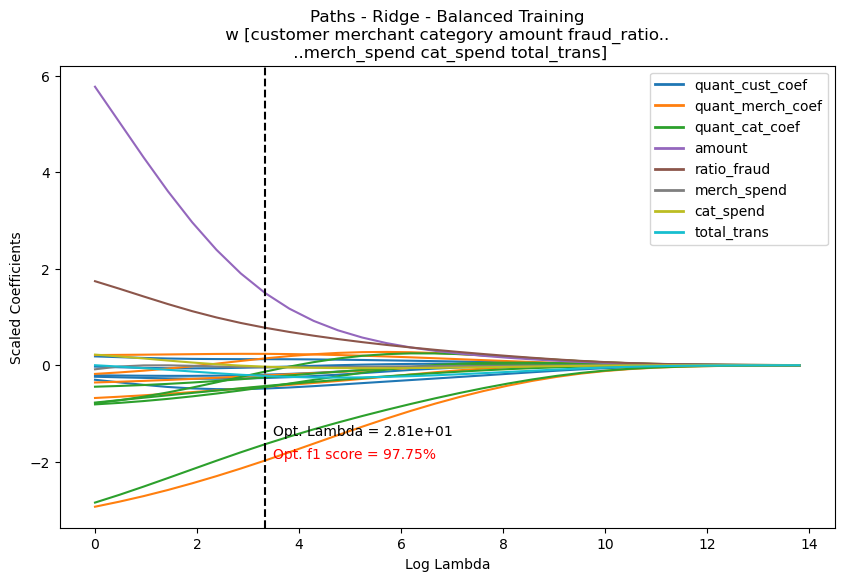

In [173]:
title = f'- Ridge - Balanced Training\n w [customer merchant category amount fraud_ratio.. \n ..merch_spend cat_spend total_trans]'
original_labels = data_temp.drop(columns=['fraud']).columns.tolist()
model_r, coefs_r, lam_r, ypred_r, group_lass_labels, labels, scores_r = (
    ridge_paths(X_train, y_train, X_test, original_labels,
                c_start=-6, c_stop=0, c_num=30,
                scoring='f1',
                n_iter=100,
                tol=1e-3,
                cmap='tab10',
                title=title,
                verbose=True,
                save_plot=False))

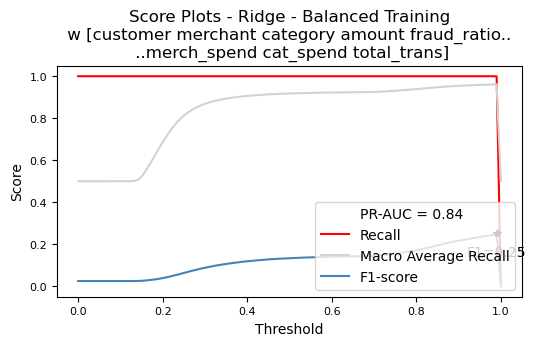

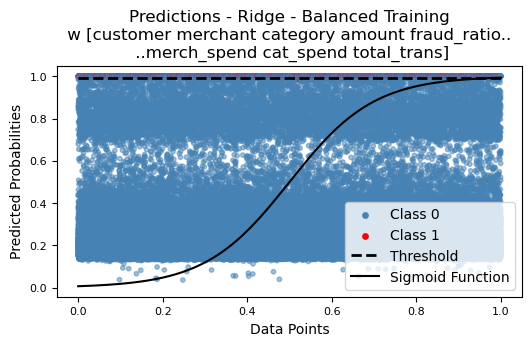

######### Ridge - Balanced Training- w [customer merchant category amount fraud_ratio.. - ..merch_spend cat_spend total_trans] #########
Confusion Matrix - Optimal Threshold = 0.990

     0    1
108634 8808
     1 1486

Classification Report - Optimal Threshold = 0.990

              precision    recall  f1-score   support

           0       1.00      0.93      0.96    117442
           1       0.14      1.00      0.25      1487

    accuracy                           0.93    118929
   macro avg       0.57      0.96      0.61    118929
weighted avg       0.99      0.93      0.95    118929



In [174]:
full_class_report(y_test, ypred_r, title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  criterion='f1_recall_diff',
                  sample0=1,
                  legend_loc='lower right', save_plot=False)

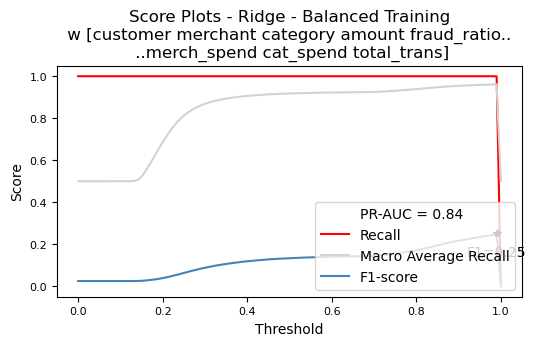

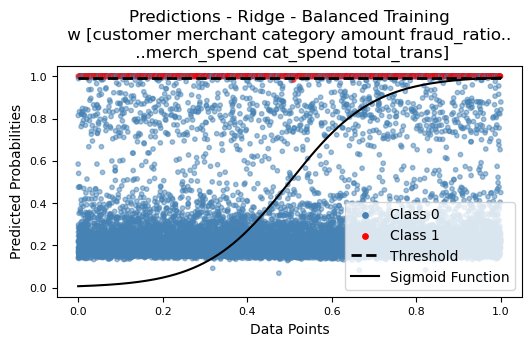

######### Ridge - Balanced Training- w [customer merchant category amount fraud_ratio.. - ..merch_spend cat_spend total_trans] #########
Confusion Matrix - Optimal Threshold = 0.990

     0    1
108634 8808
     1 1486

Classification Report - Optimal Threshold = 0.990

              precision    recall  f1-score   support

           0       1.00      0.93      0.96    117442
           1       0.14      1.00      0.25      1487

    accuracy                           0.93    118929
   macro avg       0.57      0.96      0.61    118929
weighted avg       0.99      0.93      0.95    118929



In [175]:
full_class_report(y_test, ypred_r, title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  criterion='f1_recall_diff',
                  sample0=0.1,
                  legend_loc='lower right', save_plot=False)

In [ ]:
_, pr_auc_r_balanced, recall_r_balanced, f1_r_balanced, recall_macro_r_balanced = (
    classification_plots(y_test, ypred_r, l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [177]:
print(f'pr_auc_r_balanced: {pr_auc_r_balanced},\nrecall_r_balanced: {recall_r_balanced},\nf1_r_balanced: {f1_r_balanced},\nrecall_macro_r_balanced: {recall_macro_r_balanced},')

pr_auc_r_balanced: 0.8405756145132418,
recall_r_balanced: 0.9993275050437121,
f1_r_balanced: 0.2522706052117817,
recall_macro_r_balanced: 0.9621643911349587,


In [178]:
beset_recall_r_balanced = best_recall_thresh(y_test, ypred_r, 'r_balanced', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_r_balanced)

In [179]:
scr_r_balanced = {
    'pr_auc_r_balanced': pr_auc_r_balanced,
    'recall_r_balanced': recall_r_balanced,
    'f1_r_balanced': f1_r_balanced,
    'recall_macro_r_balanced': recall_macro_r_balanced
}
scores_plot.update(scr_r_balanced)

# SVM - Balanced Training

In [180]:
C = [0.1, 1]
bias = range(1)

svm_values = svm_model(X_train, y_train, X_test, y_test,
                       C, kernel='poly',
                       degree=3,
                       bias=bias,
                       scoring='recall_macro',
                       verbose=True)

1. C = 0.1
    bias: 0
[LibSVM]2. C = 1
    bias: 0
[LibSVM]Optimal Values: recall_macro score:  0.9306,  C: 0.1,   Bias: 0


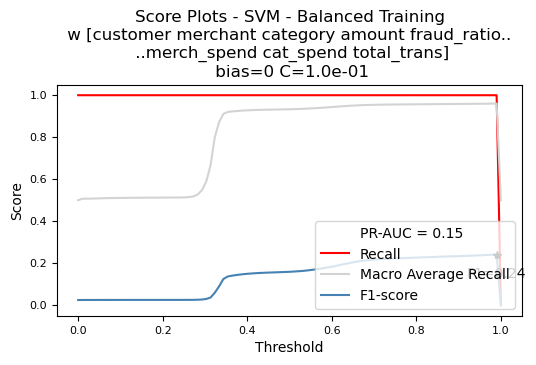

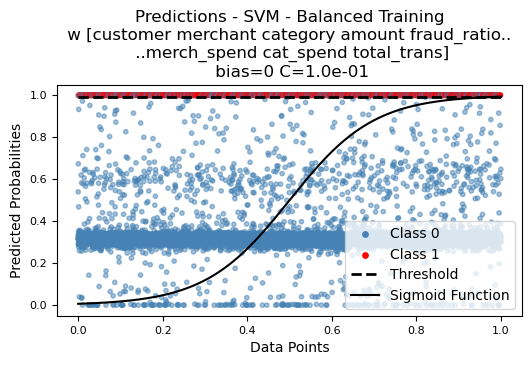

######### SVM - Balanced Training- w [customer merchant category amount fraud_ratio.. - ..merch_spend cat_spend total_trans]- bias=0 C=1.0e-01 #########
Confusion Matrix - Optimal Threshold = 0.990

     0    1
108099 9343
     0 1487

Classification Report - Optimal Threshold = 0.990

              precision    recall  f1-score   support

           0       1.00      0.92      0.96    117442
           1       0.14      1.00      0.24      1487

    accuracy                           0.92    118929
   macro avg       0.57      0.96      0.60    118929
weighted avg       0.99      0.92      0.95    118929



In [181]:
title=f"- SVM - Balanced Training\n w [customer merchant category amount fraud_ratio.. \n ..merch_spend cat_spend total_trans]\n bias={svm_values['bias_opt']} C={svm_values['C_opt']:.1e}"
full_class_report(y_test, svm_values['y_svm'], title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  criterion='f1_recall_diff',
                  sample0=0.1,
                  legend_loc='lower right', save_plot=False)

In [ ]:
_, pr_auc_svm_balanced, recall_svm_balanced, f1_svm_balanced, recall_macro_svm_balanced = (
    classification_plots(y_test, svm_values['y_svm'], l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [183]:
print(f'pr_auc_svm_balanced: {pr_auc_svm_balanced}\nrecall_svm_balanced: {recall_svm_balanced}\nf1_svm_balanced: {f1_svm_balanced}\nrecall_macro_svm_balanced: {recall_macro_svm_balanced}')

pr_auc_svm_balanced: 0.148063327690929
recall_svm_balanced: 1.0
f1_svm_balanced: 0.2414548997320776
recall_macro_svm_balanced: 0.9602229185470275


In [184]:
beset_recall_svm_balanced = best_recall_thresh(y_test, svm_values['y_svm'], 'svm_balanced', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_svm_balanced)

In [185]:
scr_svm_balanced = {
    'pr_auc_svm_balanced': pr_auc_svm_balanced,
    'recall_svm_balanced': recall_svm_balanced,
    'f1_svm_balanced': f1_svm_balanced,
    'recall_macro_svm_balanced': recall_macro_svm_balanced
}
scores_plot.update(scr_svm_balanced)

# XGB - Balanced Training

In [186]:
xgb_model, ypred_xgb = xgb_logistic_model(X_train, y_train, X_test, y_test, eval_metric='aucpr', max_depth=3, threads=4, iter=14)

[0]	train-aucpr:0.99003	eval-aucpr:0.52820
[1]	train-aucpr:0.99603	eval-aucpr:0.74662
[2]	train-aucpr:0.99756	eval-aucpr:0.82468
[3]	train-aucpr:0.99782	eval-aucpr:0.82658
[4]	train-aucpr:0.99824	eval-aucpr:0.86582
[5]	train-aucpr:0.99882	eval-aucpr:0.88063
[6]	train-aucpr:0.99888	eval-aucpr:0.89708
[7]	train-aucpr:0.99909	eval-aucpr:0.90589
[8]	train-aucpr:0.99915	eval-aucpr:0.90337
[9]	train-aucpr:0.99926	eval-aucpr:0.90386
[10]	train-aucpr:0.99940	eval-aucpr:0.90053
[11]	train-aucpr:0.99943	eval-aucpr:0.90529
[12]	train-aucpr:0.99950	eval-aucpr:0.90783
[13]	train-aucpr:0.99955	eval-aucpr:0.90917


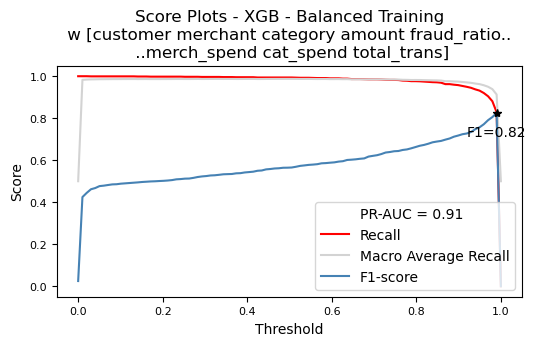

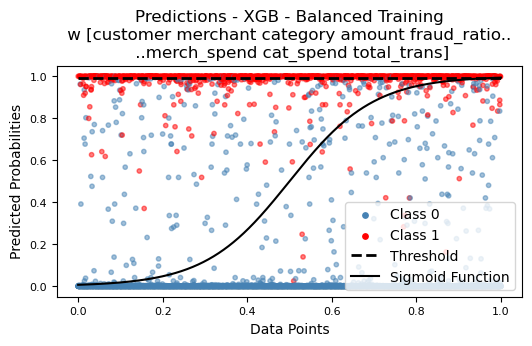

######### XGB - Balanced Training- w [customer merchant category amount fraud_ratio.. - ..merch_spend cat_spend total_trans] #########
Confusion Matrix - Optimal Threshold = 0.990

     0    1
117172  270
   255 1232

Classification Report - Optimal Threshold = 0.990

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117442
           1       0.82      0.83      0.82      1487

    accuracy                           1.00    118929
   macro avg       0.91      0.91      0.91    118929
weighted avg       1.00      1.00      1.00    118929



In [187]:
title = f'- XGB - Balanced Training\n w [customer merchant category amount fraud_ratio.. \n ..merch_spend cat_spend total_trans]'
full_class_report(y_test, ypred_xgb, title=title,
                  l_lim=0, u_lim=1, num_thresh=100,
                  sample0=0.1,
                  criterion='f1',
                  legend_loc='lower right', save_plot=False)

In [ ]:
_, pr_auc_xgb_balanced, recall_xgb_balanced, f1_xgb_balanced, recall_macro_xgb_balanced = (
    classification_plots(y_test, ypred_xgb, l_lim=0, u_lim=1, num_thresh=100,
                         criterion='f1_recall_diff', title=title, legend_loc='best',
                         save_plot=False))

In [189]:
print(f'pr_auc_xgb_balanced: {pr_auc_xgb_balanced},\nrecall_xgb_balanced: {recall_xgb_balanced},\nf1_xgb_balanced: {f1_xgb_balanced},\nrecall_macro_xgb_balanced: {recall_macro_xgb_balanced},')

pr_auc_xgb_balanced: 0.9091279968520455,
recall_xgb_balanced: 0.8285137861466039,
f1_xgb_balanced: 0.8243559718969554,
recall_macro_xgb_balanced: 0.9131073894885537,


In [190]:
beset_recall_xgb_balanced = best_recall_thresh(y_test, ypred_xgb, 'xgb_balanced', l_lim=0, u_lim=1, num_thresh=1000)
best_recall.update(beset_recall_xgb_balanced)

In [191]:
scr_xgb_balanced = {
    'pr_auc_xgb_balanced': pr_auc_xgb_balanced,
    'recall_xgb_balanced': recall_xgb_balanced,
    'f1_xgb_balanced': f1_xgb_balanced,
    'recall_macro_xgb_balanced': recall_macro_xgb_balanced
}
scores_plot.update(scr_xgb_balanced)

In [ ]:
scores_plot_save = {key: int(value) if isinstance(value, np.integer) else value for key, value in
               scores_plot.items()}
file_scores = 'scores_ridge_coefs'
with open(f'data/{file_scores}.json', 'w') as f:
    json.dump(scores_plot_save, f)

In [ ]:
best_recall_save = {key: int(value) if isinstance(value, np.integer) else value for key, value in best_recall.items()}

In [ ]:
file_best_recall = 'best_recalls'
with open(f'data/{file_best_recall}.json', 'w') as f:
    json.dump(best_recall_save, f)

## Scores were obtained above and saved to json file

In [38]:
from models import *
from used_packages import *
from utils import *

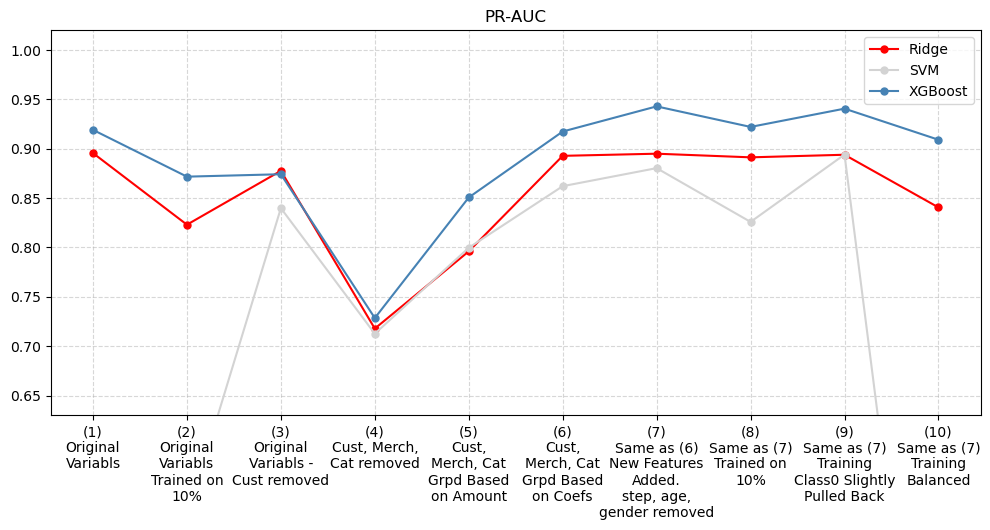

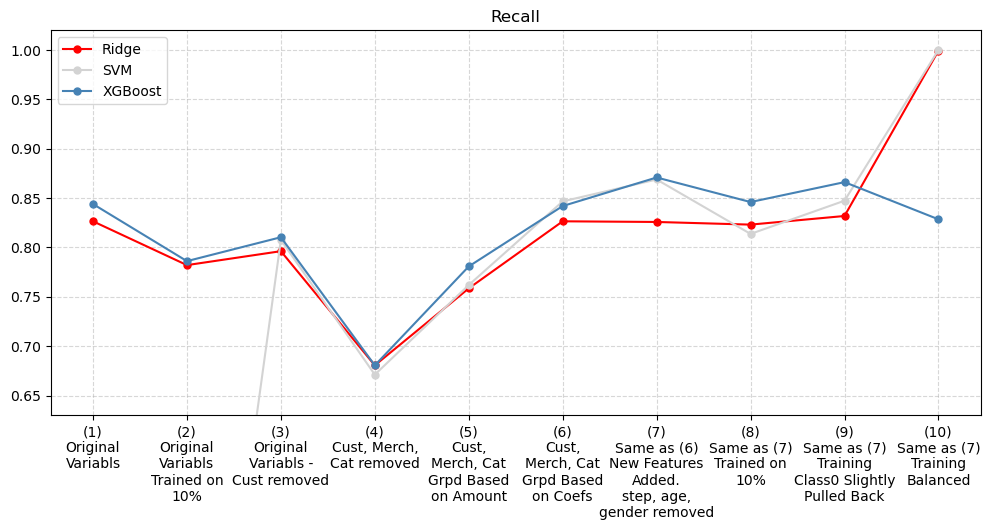

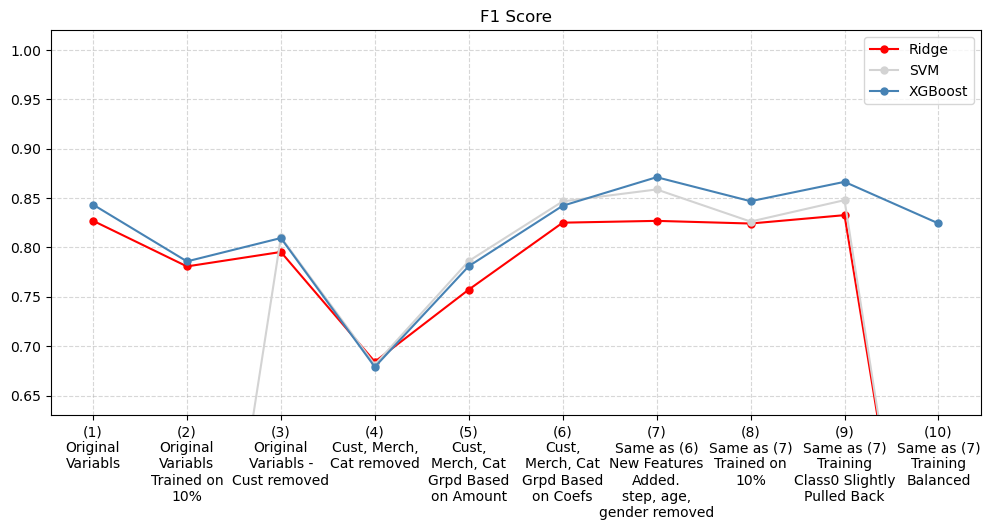

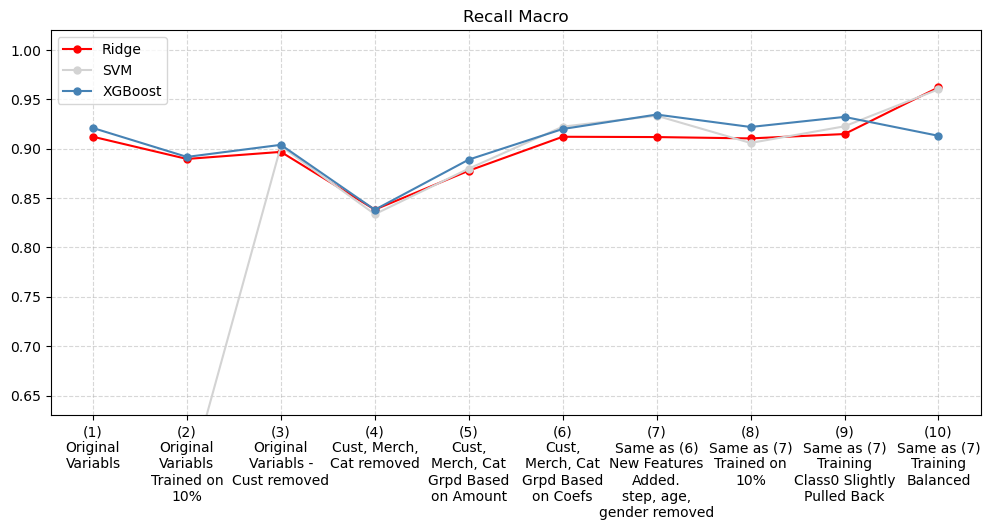

In [39]:
with open('data/scores.json', 'r') as f:
    loaded_scores = json.load(f)

model_score_plots(loaded_scores, save_plot=False, fig_size=(12,5))

In [40]:
with open('data/best_recall_numbers.json', 'r') as f:
    loaded_fn = json.load(f)

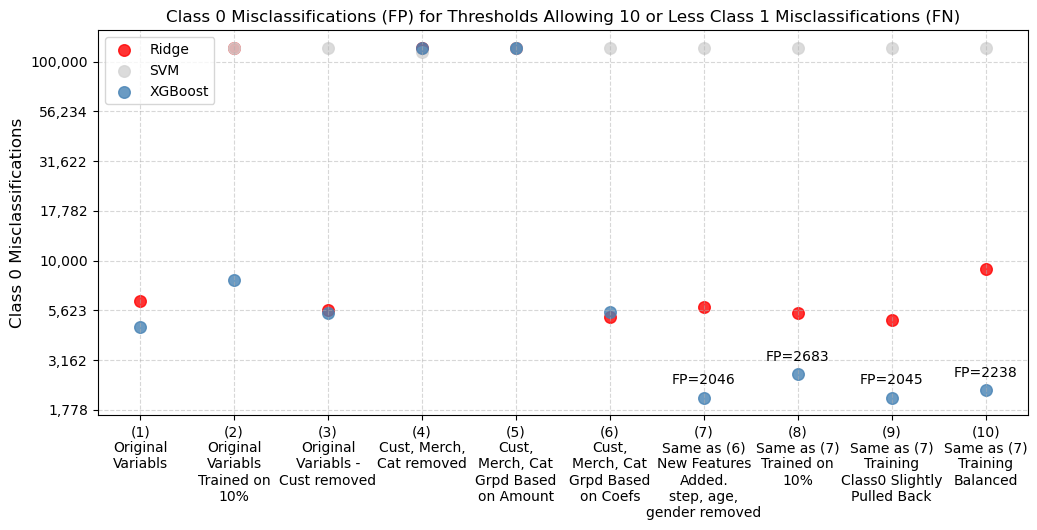

In [41]:
model_fp_plots(loaded_fn, top_models=4, save_plot=False, fig_size=(12, 5))